# MORDM Analysis
The analysis follows the four-step MORDM framework:

1. **Problem Formulation**: Define objectives, uncertainties, and policy levers
2. **Policy Discovery**: Use multi-objective evolutionary algorithms to find candidate solutions
3. **Robustness Evaluation**: Re-evaluate policies under deep uncertainty
4. **Scenario Discovery**: Identify vulnerability conditions using PRIM analysis

The analysis extends to Multi-Scenario MORDM to improve robustness and includes global sensitivity analysis.


## Phase 1: Setup and Problem Formulation

We begin by importing required libraries and configuring the model.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas import read_csv

warnings.filterwarnings('ignore')

# EMA Workbench imports
from ema_workbench import (
    ema_logging, MultiprocessingEvaluator, SequentialEvaluator,
    Scenario, Policy, save_results, load_results, Samplers,
    ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter
)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, ArchiveLogger
)
from ema_workbench.em_framework import get_SALib_problem
from ema_workbench.analysis import parcoords, prim

# SALib for sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

# Custom imports for IJssel River model
from problem_formulation import get_model_for_problem_formulation

# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

print("Libraries imported successfully")


Libraries imported successfully


### Step 1.1: Model Configuration

We configure the IJssel River model using problem formulation 2, which includes our five key performance indicators:
- Expected Annual Damage
- Dike Investment Costs
- RfR Investment Costs
- Evacuation Costs
- Expected Number of Deaths


In [3]:
# Configure problem formulation
problem_formulation_id = 2  # Matches the 5 KPIs from the project report

# Get model (handle potential tuple return)
model_result = get_model_for_problem_formulation(problem_formulation_id)
if isinstance(model_result, tuple):
    dike_model, planning_steps = model_result
else:
    dike_model = model_result
    planning_steps = [0, 1, 2]  # Default planning steps

print(f"Model Configuration:")
print(f"- Model name: {dike_model.name}")
print(f"- Number of uncertainties: {len(dike_model.uncertainties)}")
print(f"- Number of levers: {len(dike_model.levers)}")
print(f"- Number of outcomes: {len(dike_model.outcomes)}")
print(f"- Planning steps: {planning_steps}")

print("\nOutcomes (objectives to minimize):")
for outcome in dike_model.outcomes:
    print(f"  - {outcome.name}")


Model Configuration:
- Model name: dikesnet
- Number of uncertainties: 19
- Number of levers: 31
- Number of outcomes: 5
- Planning steps: [0 1 2]

Outcomes (objectives to minimize):
  - Expected Annual Damage
  - Dike Investment Costs
  - RfR Investment Costs
  - Evacuation Costs
  - Expected Number of Deaths


### Step 1.2: Reference Scenario Definition

We define a reference scenario with middle values for all uncertainties. This scenario represents a baseline condition for our initial optimization.


In [4]:
# Define reference scenario with middle values for uncertainties
reference_scenario_values = {
    # Flood wave shape (middle of range [0, 132])
    'A.0_ID flood wave shape': 66,
    
    # Discount rates for each planning step
    'discount rate 0': 2.5,  # Middle of range [1.5, 4.5]
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
}

# Add dike-specific uncertainties with middle values
for uncertainty in dike_model.uncertainties:
    if uncertainty.name not in reference_scenario_values:
        if 'Bmax' in uncertainty.name:  # Breach widths
            reference_scenario_values[uncertainty.name] = 190  # Middle of [30, 350]
        elif 'pfail' in uncertainty.name:  # Dike failure probabilities
            reference_scenario_values[uncertainty.name] = 0.5  # Middle of [0, 1]
        elif 'Brate' in uncertainty.name:  # Breach growth rates
            reference_scenario_values[uncertainty.name] = 5.5  # Middle of [1.0, 10]

# Create reference scenario object
reference_scenario = Scenario('reference', **reference_scenario_values)

print(f"Reference scenario defined with {len(reference_scenario_values)} parameters")
print("Key reference values:")
print(f"  - Flood wave shape: {reference_scenario_values['A.0_ID flood wave shape']}")
print(f"  - Discount rate: {reference_scenario_values['discount rate 0']}")
print(f"  - Breach parameters (example): Bmax=190, pfail=0.5, Brate=5.5")


Reference scenario defined with 19 parameters
Key reference values:
  - Flood wave shape: 66
  - Discount rate: 2.5
  - Breach parameters (example): Bmax=190, pfail=0.5, Brate=5.5


### Step 1.3: Optimization Parameters

We configure the NSGA-II optimization parameters. A quick test mode is available for initial testing, with production mode for full analysis.


In [5]:
# Configuration: Set to True for quick testing, False for production
QUICK_TEST = False

if QUICK_TEST:
    print("QUICK TEST MODE - for initial testing and debugging")
    nfe = 125  # Number of function evaluations
    epsilon = [0.1] * len(dike_model.outcomes)  # Larger epsilon for faster convergence
    n_reevaluation_scenarios = 25  # Scenarios for re-evaluation
    n_sobol_samples = 32   # SOBOL samples for testing (32 * 42 = ~1,350 experiments)
    runtime_estimate = "70-85 minutes"
    print(f"Test parameters: NFE={nfe}, epsilon={epsilon[0]}, scenarios={n_reevaluation_scenarios}")
    print(f"Expected runtime: {runtime_estimate}")
else:
    print("MODIFIED PRODUCTION MODE - Balanced analysis for overnight execution")
    nfe = 10000  # Full optimization quality
    epsilon = [0.05] * len(dike_model.outcomes)  # Fine-grained epsilon
    n_reevaluation_scenarios = 1000  # Full robustness evaluation
    n_sobol_samples = 64   # Reduced SOBOL for reasonable runtime (64 * 42 = ~2,700 experiments)
    runtime_estimate = "10-13 hours"
    print(f"Production parameters: NFE={nfe}, epsilon={epsilon[0]}, scenarios={n_reevaluation_scenarios}")
    print(f"SOBOL samples: {n_sobol_samples} (balanced for overnight run)")
    print(f"Expected runtime: {runtime_estimate}")

print(f"\nConfiguration Summary:")
print(f"- Optimization: {nfe} function evaluations")
print(f"- Robustness: {n_reevaluation_scenarios} scenarios")
print(f"- SOBOL: {n_sobol_samples} base samples → ~{n_sobol_samples * (2 * len(dike_model.uncertainties) + 2)} evaluations")
print(f"- Total estimated runtime: {runtime_estimate}")

print(f"\nObjectives and epsilon values:")
for i, outcome in enumerate(dike_model.outcomes):
    print(f"  {outcome.name}: epsilon = {epsilon[i]}")


MODIFIED PRODUCTION MODE - Balanced analysis for overnight execution
Production parameters: NFE=10000, epsilon=0.05, scenarios=1000
SOBOL samples: 64 (balanced for overnight run)
Expected runtime: 10-13 hours

Configuration Summary:
- Optimization: 10000 function evaluations
- Robustness: 1000 scenarios
- SOBOL: 64 base samples → ~2560 evaluations
- Total estimated runtime: 10-13 hours

Objectives and epsilon values:
  Expected Annual Damage: epsilon = 0.05
  Dike Investment Costs: epsilon = 0.05
  RfR Investment Costs: epsilon = 0.05
  Evacuation Costs: epsilon = 0.05
  Expected Number of Deaths: epsilon = 0.05


## Phase 2: Single-Scenario MORDM - Policy Discovery

This phase implements the core MORDM optimization using NSGA-II to find Pareto-optimal policies under the reference scenario.


### Step 2.1: MOEA Policy Discovery (don'run again, results are saved)

We run the NSGA-II optimization with convergence tracking to find candidate policies that represent different trade-offs between objectives.


In [6]:
# Setup convergence tracking
convergence_metrics = [EpsilonProgress()]

# Run NSGA-II optimization
print("Starting NSGA-II optimization...")
print(f"Optimizing {len(dike_model.levers)} levers across {len(dike_model.outcomes)} objectives")

with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_results = evaluator.optimize(
        nfe=nfe,
        searchover='levers',
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario
    )

# Extract results
archive, convergence = optimization_results

print(f"\nOptimization completed:")
print(f"- Archive size: {len(archive)} solutions")
print(f"- Function evaluations: {nfe}")

# Check if convergence data exists
if len(convergence.epsilon_progress) > 0:
    print(f"- Final epsilon progress: {convergence.epsilon_progress.iloc[-1]:.4f}")
else:
    print("- No convergence data recorded")

# Display convergence data info
print(f"- Convergence tracking: {len(convergence.epsilon_progress)} data points")

# Save optimization results - archive only (avoids convergence serialization issues)
try:
    # Save the archive (most important data)
    archive.to_csv(f'IJssel_MORDM_archive_nfe{nfe}.csv')
    print("Archive saved to CSV file")
    
    # Save convergence data separately if it exists
    if len(convergence.epsilon_progress) > 0:
        convergence_df = pd.DataFrame({
            'nfe': convergence.nfe,
            'epsilon_progress': convergence.epsilon_progress
        })
        convergence_df.to_csv(f'IJssel_MORDM_convergence_nfe{nfe}.csv', index=False)
        print("Convergence data saved to CSV file")
    
    print("Results saved successfully")
except Exception as e:
    print(f"Warning: Could not save results - {str(e)}")
    print("Continuing with analysis...")


Starting NSGA-II optimization...
Optimizing 31 levers across 5 objectives


[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████| 10000/10000 [10:39<00:00, 15.65it/s]
[MainProcess/INFO] optimization completed, found 218 solutions
[MainProcess/INFO] terminating pool



Optimization completed:
- Archive size: 218 solutions
- Function evaluations: 10000
- Final epsilon progress: 1080.0000
- Convergence tracking: 12 data points
Archive saved to CSV file
Convergence data saved to CSV file
Results saved successfully


### Step 2.2: Convergence Analysis

We analyze the convergence of the NSGA-II algorithm to ensure that the optimization has found a stable set of solutions.


In [7]:
# Force load the NFE 10000 convergence data
try:
    # Load the specific NFE 10000 convergence file
    convergence_file = 'IJssel_MORDM_convergence_nfe10000.csv'
    convergence_df = pd.read_csv(convergence_file)

    # Create a simple convergence object with the loaded data
    class ConvergenceData:
        def __init__(self, df):
            self.nfe = df['nfe'].values if 'nfe' in df.columns else range(len(df))
            self.epsilon_progress = df['epsilon_progress'].values if 'epsilon_progress' in df.columns else df.iloc[:, -1].values

    convergence = ConvergenceData(convergence_df)
    print(f"Loaded convergence data from {convergence_file}")
    print(f"Convergence data points: {len(convergence.epsilon_progress)}")
    print(f"NFE range: {convergence.nfe[0]} to {convergence.nfe[-1]}")

except FileNotFoundError:
    print("IJssel_MORDM_convergence_nfe10000.csv not found. Please run the optimization first.")
    convergence = None
except Exception as e:
    convergence = None
    print(f"Could not load convergence data: {str(e)}")

# Plot convergence
fig, ax = plt.subplots(figsize=(10, 6))

# Check if convergence data exists
if convergence is not None and hasattr(convergence, 'epsilon_progress') and len(convergence.epsilon_progress) > 0:
    ax.plot(convergence.nfe, convergence.epsilon_progress, 'b-', linewidth=2)
    ax.set_xlabel('Number of Function Evaluations')
    ax.set_ylabel('Epsilon Progress')
    ax.set_title('NSGA-II Convergence Analysis')
    ax.grid(True, alpha=0.3)

    # Add convergence threshold line
    threshold = 0.01
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'Convergence threshold ({threshold})')
    ax.legend()

    # Convergence assessment
    final_progress = convergence.epsilon_progress[-1]
    is_converged = final_progress < threshold
    print(f"Convergence Assessment:")
    print(f"- Final epsilon progress: {final_progress:.6f}")
    print(f"- Converged (< {threshold}): {is_converged}")
else:
    ax.text(0.5, 0.5, 'No convergence data available\nOptimization may have completed too quickly\nor convergence file not found',
            ha='center', va='center', transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax.set_title('NSGA-II Convergence Analysis - No Data')
    print(f"Convergence Assessment:")
    print(f"- No convergence data recorded")
    print(f"- This may occur with very small NFE values or missing convergence files")

# Try to get archive info
if 'archive' in locals() and archive is not None:
    print(f"- Archive diversity: {len(archive)} unique solutions")
else:
    print("- Archive not available in memory")

plt.tight_layout()
plt.show()


### Step 2.3: Pareto Frontier Visualization

We visualize the trade-offs between objectives using parallel coordinate plots to understand the relationships between different flood management strategies.


Archive loaded from IJssel_MORDM_archive_nfe10000.csv: 232 solutions
Archive shape: (232, 36)


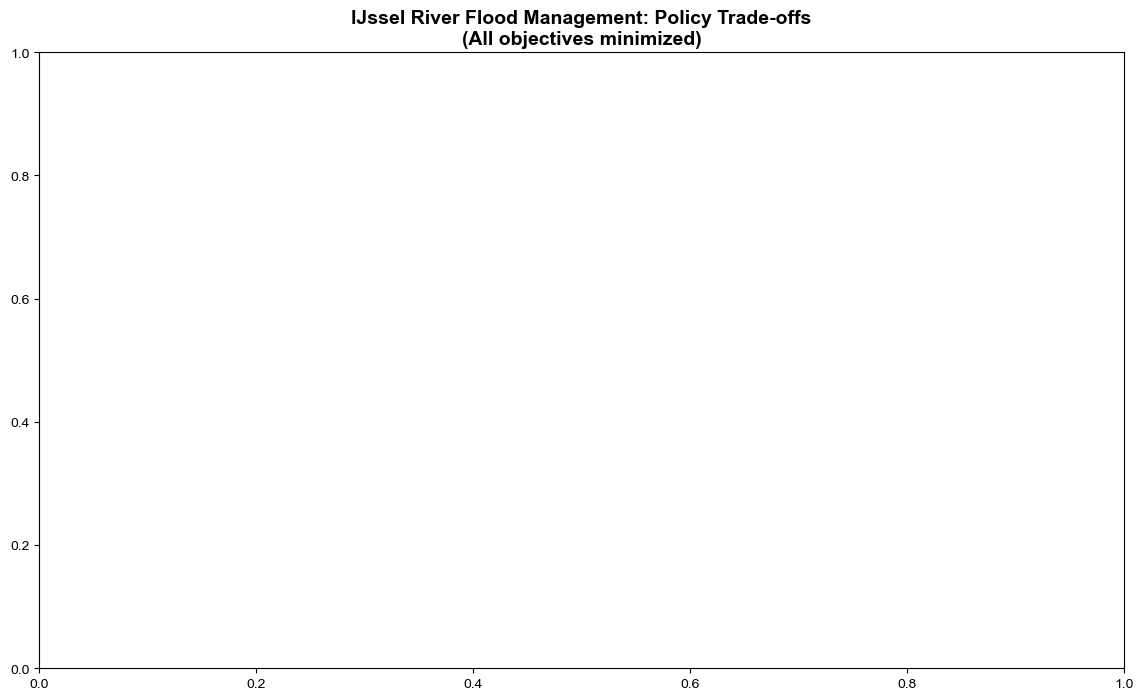

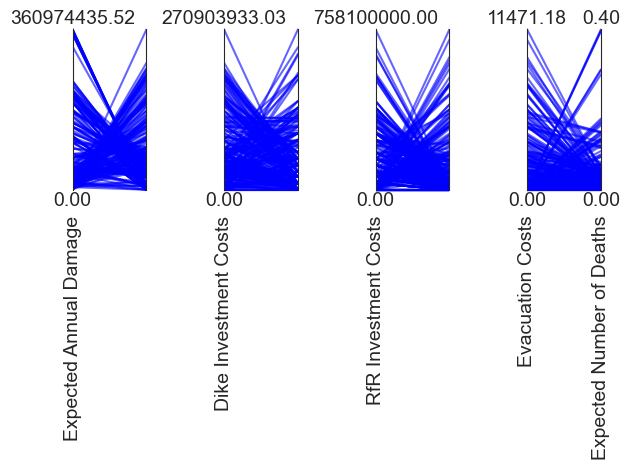

Archive Summary Statistics:
       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
count            2.320000e+02           2.320000e+02          2.320000e+02   
mean             9.292685e+07           6.749749e+07          1.409142e+08   
std              9.451898e+07           5.914520e+07          1.533645e+08   
min              0.000000e+00           0.000000e+00          0.000000e+00   
25%              1.692043e+07           2.180069e+07          3.070000e+07   
50%              4.827280e+07           5.046270e+07          8.460000e+07   
75%              1.578562e+08           1.070710e+08          2.320750e+08   
max              3.609744e+08           2.709039e+08          7.581000e+08   

       Evacuation Costs  Expected Number of Deaths  
count        232.000000                 232.000000  
mean        1740.279368                   0.040350  
std         2391.832223                   0.064006  
min            0.000000                   0.000000  
25% 

In [6]:
# Force load the NFE 10000 archive data
try:
    # Load the specific NFE 10000 archive file
    archive_file = 'IJssel_MORDM_archive_nfe10000.csv'
    archive = pd.read_csv(archive_file, index_col=0)
    print(f"Archive loaded from {archive_file}: {len(archive)} solutions")
    print(f"Archive shape: {archive.shape}")
except FileNotFoundError:
    print("IJssel_MORDM_archive_nfe10000.csv not found. Please run the optimization first.")
    raise
except Exception as e:
    print(f"Could not load archive: {str(e)}")
    raise

# Extract outcomes for visualization
outcomes_data = archive.loc[:, [o.name for o in dike_model.outcomes]]

# Create parallel coordinates plot
fig, ax = plt.subplots(figsize=(14, 8))

# Get limits for parallel coordinates
limits = parcoords.get_limits(outcomes_data)

# Create parallel axes
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(outcomes_data, alpha=0.6, color='blue')

# Customize plot
ax.set_title('IJssel River Flood Management: Policy Trade-offs\n(All objectives minimized)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("Archive Summary Statistics:")
print(outcomes_data.describe())

print(f"\nObjective ranges in archive:")
for outcome in dike_model.outcomes:
    min_val = outcomes_data[outcome.name].min()
    max_val = outcomes_data[outcome.name].max()
    print(f"  {outcome.name}: [{min_val:.2e}, {max_val:.2e}]")


## Phase 3: Robustness Evaluation and Vulnerability Analysis

This phase evaluates the robustness of candidate policies by re-evaluating them under deep uncertainty and applying constraints based on stakeholder preferences.


In [7]:
# Load Archive from File (if not already in memory)
if 'archive' not in locals() or archive is None:
    try:
        archive = pd.read_csv('IJssel_MORDM_archive_nfe10000.csv', index_col=0)
        print(f"Archive loaded from file: {len(archive)} solutions")
    except FileNotFoundError:
        print("Archive file not found. Please run the optimization phase first (Cell 11)")
        print("Or check if the file exists in your directory")
else:
    print(f"Archive already in memory: {len(archive)} solutions")


Archive already in memory: 232 solutions


### Step 3.1: Filter Candidate Policies

We apply stakeholder constraints to filter the archive to policies that meet minimum acceptability criteria.


In [8]:
# Define constraint criteria based on stakeholder preferences
# These thresholds should be adjusted based on your project's stakeholder analysis

# Calculate total deaths across all dike rings
death_columns = [col for col in archive.columns if 'Expected Number of Deaths' in col]
if death_columns:
    archive['Total_Deaths'] = archive[death_columns].sum(axis=1)
else:
    # Alternative if outcomes are aggregated differently
    archive['Total_Deaths'] = archive.get('Expected Number of Deaths', 0)

# Apply constraints
max_acceptable_deaths = 0.01  # Adjust based on stakeholder tolerance
max_acceptable_damage = 1e8   # 100 million euros
max_total_investment = 5e9    # 5 billion euros

# Filter policies
constraints = (
    (archive['Total_Deaths'] <= max_acceptable_deaths) &
    (archive.get('Expected Annual Damage', 0) <= max_acceptable_damage)
)

filtered_archive = archive[constraints].copy()

print(f"Policy Filtering Results:")
print(f"- Original archive size: {len(archive)}")
print(f"- After applying constraints: {len(filtered_archive)}")
print(f"- Retention rate: {len(filtered_archive)/len(archive)*100:.1f}%")

print(f"\nConstraints applied:")
print(f"- Maximum deaths: {max_acceptable_deaths}")
print(f"- Maximum damage: {max_acceptable_damage:.0e}")

if len(filtered_archive) == 0:
    print("WARNING: No policies satisfy constraints. Relaxing constraints...")
    # Use top 20% of policies by total deaths
    n_policies = max(10, len(archive) // 5)
    filtered_archive = archive.nsmallest(n_policies, 'Total_Deaths')
    print(f"Using top {len(filtered_archive)} policies with lowest death rates")


Policy Filtering Results:
- Original archive size: 232
- After applying constraints: 83
- Retention rate: 35.8%

Constraints applied:
- Maximum deaths: 0.01
- Maximum damage: 1e+08


### Step 3.2: Re-evaluate Under Deep Uncertainty

We convert filtered policies to Policy objects and re-evaluate them across a large ensemble of scenarios to assess their robustness.


In [9]:
# Load External Robustness Results
# The robustness analysis was completed using a standalone script to avoid notebook interruptions

import pandas as pd
import numpy as np
import glob

print("Loading robustness results from external analysis...")

# Load the results files (adjust timestamp as needed)
timestamp = "20250616_152459"  # Update this to match your actual files

try:
    # Load experiments and outcomes
    experiments_robust = pd.read_csv(f'IJssel_robustness_experiments_{timestamp}.csv', index_col=0)
    outcomes_robust_df = pd.read_csv(f'IJssel_robustness_outcomes_{timestamp}.csv', index_col=0)
    
    # Convert outcomes DataFrame back to dictionary format expected by rest of notebook
    outcomes_robust = {}
    for col in outcomes_robust_df.columns:
        outcomes_robust[col] = outcomes_robust_df[col].values
    
    print(f"Successfully loaded robustness results:")
    print(f"- Experiments: {len(experiments_robust)} rows")
    print(f"- Outcomes: {len(outcomes_robust_df)} rows, {len(outcomes_robust_df.columns)} objectives")
    print(f"- Total evaluations: {len(experiments_robust)}")
    
    # Extract policy information for consistency with notebook
    unique_policies = experiments_robust['policy'].unique()
    n_reevaluation_scenarios = len(experiments_robust) // len(unique_policies)
    policies_to_evaluate = []  # Placeholder - actual Policy objects not needed for analysis
    policy_names = [f"Policy_{i:03d}" for i in range(len(unique_policies))]
    
    print(f"- Unique policies: {len(unique_policies)}")
    print(f"- Scenarios per policy: {n_reevaluation_scenarios}")
    
except FileNotFoundError as e:
    print(f"Could not find robustness results files: {e}")
    print("Please check the timestamp in the filename and update the 'timestamp' variable above")
    print("Available files with 'robustness' in name:")
    
    import glob
    robustness_files = glob.glob("*robustness*")
    for file in robustness_files:
        print(f"  - {file}")
        
except Exception as e:
    print(f"Error loading robustness results: {e}")
    print("Please check the file format and try again")


Loading robustness results from external analysis...
Successfully loaded robustness results:
- Experiments: 5000 rows
- Outcomes: 5000 rows, 4 objectives
- Total evaluations: 5000
- Unique policies: 5
- Scenarios per policy: 1000


## (don'run again, results are saved)

In [12]:
# Convert filtered policies to Policy objects
policies_to_evaluate = []
policy_names = []

# Get lever columns (exclude outcome columns)
lever_columns = [lever.name for lever in dike_model.levers]
policies_data = filtered_archive[lever_columns]

for i, (idx, policy_row) in enumerate(policies_data.iterrows()):
    policy_dict = policy_row.to_dict()
    policy_name = f"Policy_{i:03d}"
    policies_to_evaluate.append(Policy(policy_name, **policy_dict))
    policy_names.append(policy_name)

print(f"Created {len(policies_to_evaluate)} Policy objects for re-evaluation")

# Re-evaluate policies under uncertainty
print(f"Re-evaluating policies over {n_reevaluation_scenarios} scenarios...")
print("This may take several minutes...")

with MultiprocessingEvaluator(dike_model) as evaluator:
    robustness_results = evaluator.perform_experiments(
        scenarios=n_reevaluation_scenarios,
        policies=policies_to_evaluate
    )

experiments_robust, outcomes_robust = robustness_results

print(f"Re-evaluation completed:")
print(f"- Total experiments: {len(experiments_robust)}")
print(f"- Policies evaluated: {len(policies_to_evaluate)}")
print(f"- Scenarios per policy: {n_reevaluation_scenarios}")

# Save robustness results
try:
    # Save experiments DataFrame
    experiments_robust.to_csv(f'IJssel_robustness_experiments_n{n_reevaluation_scenarios}.csv')
    
    # Save outcomes (convert dict to DataFrame first)
    outcomes_df = pd.DataFrame(outcomes_robust)
    outcomes_df.to_csv(f'IJssel_robustness_outcomes_n{n_reevaluation_scenarios}.csv')
    print("Robustness results saved to CSV files")
except Exception as e:
    print(f"Warning: Could not save robustness results - {str(e)}")
    print("Continuing with analysis...")


Created 80 Policy objects for re-evaluation
Re-evaluating policies over 1000 scenarios...
This may take several minutes...


[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 80 policies * 1 model(s) = 80000 experiments
100%|██████████████████████████████████| 80000/80000 [1:33:41<00:00, 14.23it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Re-evaluation completed:
- Total experiments: 80000
- Policies evaluated: 80
- Scenarios per policy: 1000
Robustness results saved to CSV files


### Step 3.3: Robustness Metrics Calculation 

We calculate signal-to-noise ratio and maximum regret metrics to assess policy robustness across uncertain conditions.


In [10]:
# Fix: Re-load outcomes data properly (without index_col=0)
print("Fixing the data loading issue...")

timestamp = "20250616_152459"

# Load without treating first column as index
outcomes_debug = outcomes_df

print(f"Columns in CSV file: {list(outcomes_debug.columns)}")
print(f"Shape of outcomes file: {outcomes_debug.shape}")

# Check if we now have Expected Annual Damage
if 'Expected Annual Damage' in outcomes_debug.columns:
    print(" 'Expected Annual Damage' found!")
    
    # Rebuild the outcomes_robust dictionary with ALL columns
    outcomes_robust = {}
    for col in outcomes_debug.columns:
        outcomes_robust[col] = outcomes_debug[col].values

    print(f" Rebuilt outcomes_robust with all {len(outcomes_robust)} objectives")
    print(f"All objectives: {list(outcomes_robust.keys())}")
    
    # Update outcome_names for the metrics calculation
    outcome_names = list(outcomes_robust.keys())
    print(f" Ready for metrics calculation with {len(outcome_names)} outcomes")
    
else:
    print(" Still missing 'Expected Annual Damage'")
    print("Available columns:", list(outcomes_debug.columns))


Fixing the data loading issue...


NameError: name 'outcomes_df' is not defined

In [11]:
# Define robustness metric functions
def calculate_snr(data, minimize=True):
    """Calculate Signal-to-Noise Ratio"""
    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        return 0
    if minimize:
        return -mean_val / std_val  # Prefer low mean, low std
    else:
        return mean_val / std_val   # Prefer high mean, low std

def calculate_max_regret(policy_outcomes, all_outcomes_array):
    """Calculate Maximum Regret"""
    regrets = []
    for scenario_idx in range(len(policy_outcomes)):
        # Best performance in this scenario (minimum for minimization objectives)
        best_performance = np.min(all_outcomes_array[:, scenario_idx])
        regret = policy_outcomes[scenario_idx] - best_performance
        regrets.append(regret)
    return np.max(regrets)

# Check what outcome columns are available in loaded data
print("Available outcome columns in loaded data:")
available_outcomes = list(outcomes_robust.keys())
for col in available_outcomes:
    print(f"  - {col}")

# Use available outcomes instead of model.outcomes (which may have different names)
outcome_names = available_outcomes

# Calculate robustness metrics for each policy and outcome
robustness_metrics = {}

print(f"\nCalculating robustness metrics for {len(outcome_names)} outcomes...")

for outcome_name in outcome_names:
    print(f"Processing {outcome_name}...")
    
    # Get outcomes data for this objective
    outcome_data = outcomes_robust[outcome_name]
    
    # Get number of unique policies from loaded data
    n_policies = len(unique_policies)
    
    # Reshape data: rows = policies, columns = scenarios
    # outcome_data is already a numpy array, no need for .values
    outcome_matrix = outcome_data.reshape(n_policies, n_reevaluation_scenarios)
    
    snr_values = []
    max_regret_values = []
    
    # Use policy names from loaded data
    loaded_policy_names = [f"Policy_{i:03d}" for i in range(n_policies)]
    
    for policy_idx, policy_name in enumerate(loaded_policy_names):
        policy_outcomes = outcome_matrix[policy_idx, :]
        
        # Calculate SNR (all objectives are minimized)
        snr = calculate_snr(policy_outcomes, minimize=True)
        snr_values.append(snr)
        
        # Calculate Maximum Regret
        max_regret = calculate_max_regret(policy_outcomes, outcome_matrix)
        max_regret_values.append(max_regret)
    
    robustness_metrics[outcome_name] = {
        'SNR': snr_values,
        'Max_Regret': max_regret_values
    }

print("Robustness metrics calculation completed")

# Create summary DataFrames using loaded policy names
loaded_policy_names = [f"Policy_{i:03d}" for i in range(n_policies)]
snr_df = pd.DataFrame({outcome: robustness_metrics[outcome]['SNR'] 
                       for outcome in outcome_names}, index=loaded_policy_names)
regret_df = pd.DataFrame({outcome: robustness_metrics[outcome]['Max_Regret'] 
                         for outcome in outcome_names}, index=loaded_policy_names)

print(f"\nSignal-to-Noise Ratio (higher is better for robustness):")
print(snr_df.describe())

print(f"\nMaximum Regret (lower is better for robustness):")
print(regret_df.describe())


Available outcome columns in loaded data:
  - Dike Investment Costs
  - RfR Investment Costs
  - Evacuation Costs
  - Expected Number of Deaths

Calculating robustness metrics for 4 outcomes...
Processing Dike Investment Costs...
Processing RfR Investment Costs...
Processing Evacuation Costs...
Processing Expected Number of Deaths...
Robustness metrics calculation completed

Signal-to-Noise Ratio (higher is better for robustness):
       Dike Investment Costs  RfR Investment Costs  Evacuation Costs  \
count           5.000000e+00                   5.0          5.000000   
mean           -1.439275e+15                   0.0         -0.781435   
std             1.997668e+15                   0.0          0.111556   
min            -4.059903e+15                   0.0         -0.951340   
25%            -3.136471e+15                   0.0         -0.820019   
50%             0.000000e+00                   0.0         -0.741848   
75%             0.000000e+00                   0.0         -0

## Phase 4: Scenario Discovery Using PRIM

We use Patient Rule Induction Method (PRIM) to identify combinations of uncertainties that lead to policy failures or unacceptable outcomes.


In [63]:

outcomes_robust = pd.read_csv("IJssel_robustness_outcomes_n1000.csv")
experiments_robust = pd.read_csv("IJssel_robustness_experiments_n1000.csv")
# Identify uncertainty columns (exclude policy and scenario columns)
exclude_columns = ['policy', 'scenario', 'model']
if 'Unnamed: 0' in experiments_robust.columns:
    exclude_columns.append('Unnamed: 0')

uncertainty_columns = [col for col in experiments_robust.columns if col not in exclude_columns]

# Get lever names to exclude them too (if dike_model is available)
if 'dike_model' in locals():
    try:
        lever_names = [lever.name for lever in dike_model.levers]
        uncertainty_columns = [col for col in uncertainty_columns if col not in lever_names]
        print(f"Excluded {len(lever_names)} policy lever columns")
    except:
        print("Could not access lever names from dike_model")

print(f"Using {len(uncertainty_columns)} uncertainty columns for PRIM:")
for col in uncertainty_columns:
    print(f"  - {col}")

experiments_for_prim = experiments_robust[uncertainty_columns]

# Define failure criteria (adjust these based on your stakeholder analysis)
high_damage_threshold = 5e7  # 50 million euros
high_deaths_threshold = 0.005  # 0.005 deaths per year

# Create failure indicators
high_damage = outcomes_robust.get('Expected Annual Damage', 0) > high_damage_threshold

# Handle deaths - may be aggregated or disaggregated
if 'Expected Number of Deaths' in outcomes_robust:
    high_deaths = outcomes_robust['Expected Number of Deaths'] > high_deaths_threshold
else:
    # Sum across all dike rings if disaggregated
    death_outcomes = [col for col in outcomes_robust.columns if 'Deaths' in col]
    if death_outcomes:
        total_deaths = sum([outcomes_robust[col] for col in death_outcomes])
        high_deaths = total_deaths > high_deaths_threshold
    else:
        high_deaths = pd.Series([False] * len(experiments_robust))

print(f"PRIM Analysis Setup:")
print(f"- High damage threshold: {high_damage_threshold:.0e}")
print(f"- High deaths threshold: {high_deaths_threshold}")
print(f"- High damage cases: {high_damage.sum()} / {len(high_damage)} ({high_damage.mean()*100:.1f}%)")
print(f"- High deaths cases: {high_deaths.sum()} / {len(high_deaths)} ({high_deaths.mean()*100:.1f}%)")

# Run PRIM for high damage scenarios
print("\nRunning PRIM for high damage scenarios...")
prim_damage = prim.Prim(experiments_for_prim, high_damage, threshold=0.8, peel_alpha=0.05)
box_damage = prim_damage.find_box()

# Run PRIM for high deaths scenarios
print("Running PRIM for high deaths scenarios...")
prim_deaths = prim.Prim(experiments_for_prim, high_deaths, threshold=0.8, peel_alpha=0.05)
box_deaths = prim_deaths.find_box()

print("PRIM analysis completed")


FileNotFoundError: [Errno 2] No such file or directory: 'IJssel_robustness_outcomes_n1000.csv'

Creating PRIM visualizations...
\nHigh Damage PRIM Box:


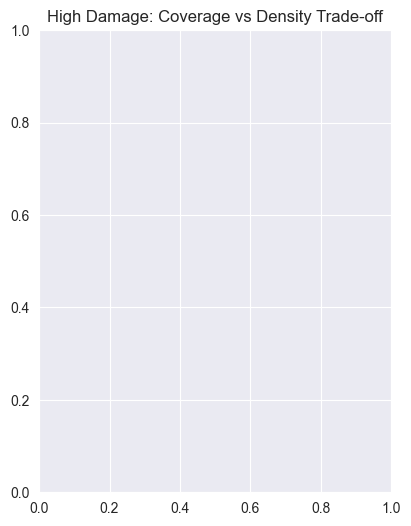

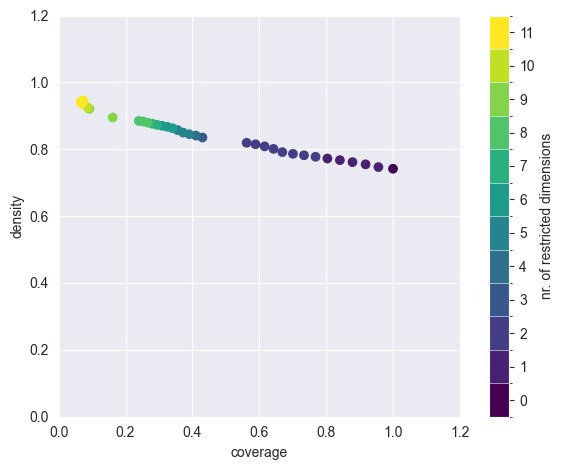

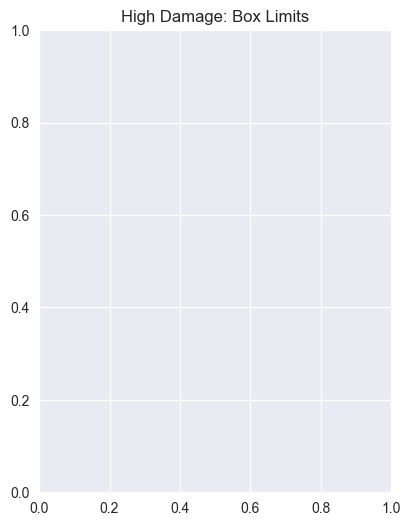

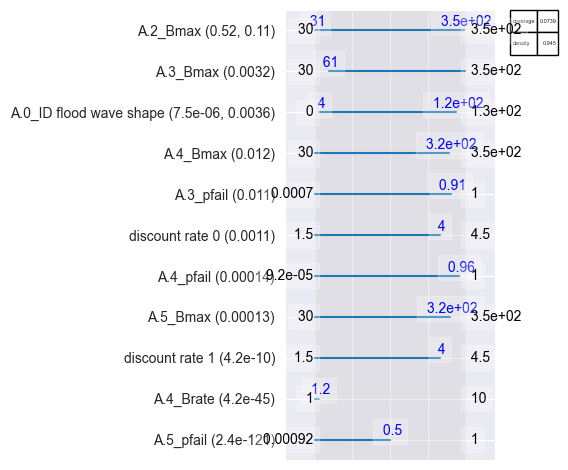

\nHigh Deaths PRIM Box:


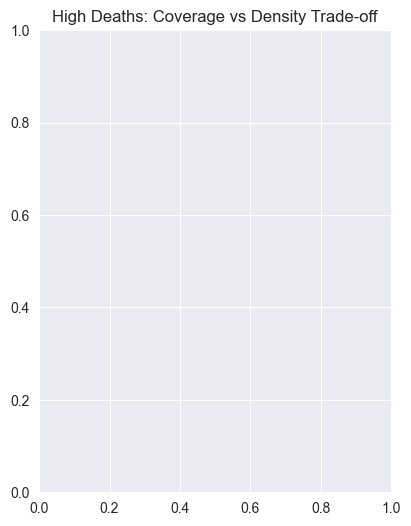

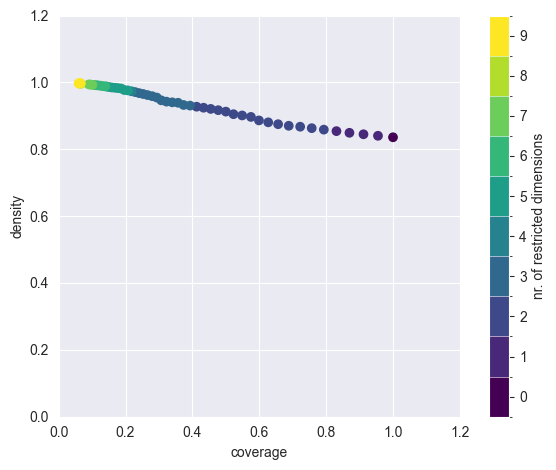

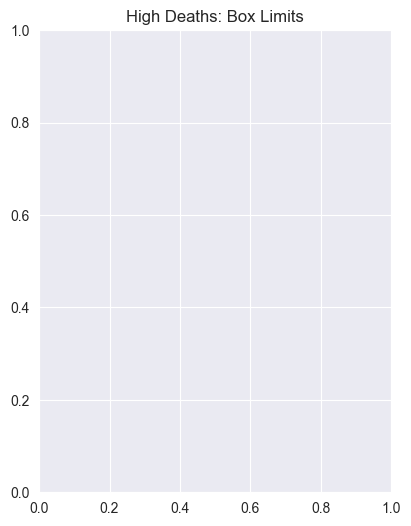

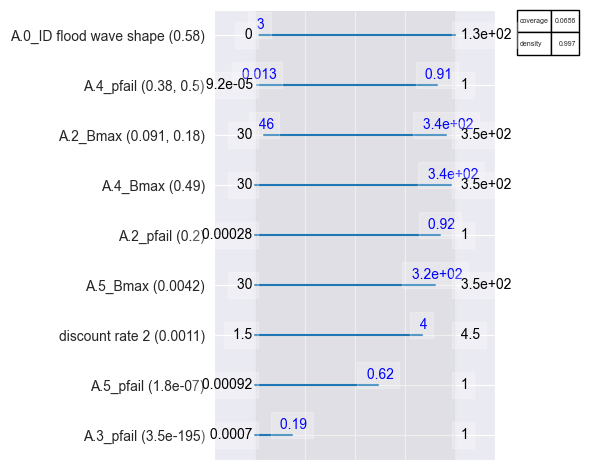

\nPRIM Box Analysis - High Damage Scenarios:
Coverage: 0.074
Density: 0.945
Box limits:
  Box limits available: 38 boxes
\nPRIM Box Analysis - High Deaths Scenarios:
Coverage: 0.066
Density: 0.997
Box limits:
  Box limits available: 58 boxes
\nSelected 4640 vulnerable scenarios from PRIM box


In [22]:
# Visualize PRIM results
print("Creating PRIM visualizations...")

# High damage PRIM results
print("\\nHigh Damage PRIM Box:")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('High Damage: Coverage vs Density Trade-off')
try:
    box_damage.show_tradeoff()  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create tradeoff plot: {e}")
    plt.close()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)  
plt.title('High Damage: Box Limits')
try:
    box_damage.inspect(style='graph')  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create inspection plot: {e}")
    plt.close()

# High deaths PRIM results
print("\\nHigh Deaths PRIM Box:")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('High Deaths: Coverage vs Density Trade-off')
try:
    box_deaths.show_tradeoff()  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create tradeoff plot: {e}")
    plt.close()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)
plt.title('High Deaths: Box Limits') 
try:
    box_deaths.inspect(style='graph')  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create inspection plot: {e}")
    plt.close()

# Print PRIM box details
print("\\nPRIM Box Analysis - High Damage Scenarios:")
try:
    print(f"Coverage: {box_damage.coverage:.3f}")
    print(f"Density: {box_damage.density:.3f}")
    
    # Try different ways to access box limits
    print("Box limits:")
    try:
        # Method 1: Try .limits attribute
        for var, (lower, upper) in box_damage.limits.items():
            print(f"  {var}: [{lower:.3f}, {upper:.3f}]")
    except AttributeError:
        try:
            # Method 2: Try .box_lims attribute
            if hasattr(box_damage, 'box_lims'):
                print(f"  Box limits available: {len(box_damage.box_lims)} boxes")
            else:
                print("  Box limits format not accessible in this version")
        except:
            print("  Could not access box limit details")
            
except Exception as e:
    print(f"Could not access high damage PRIM box details: {e}")

print("\\nPRIM Box Analysis - High Deaths Scenarios:")
try:
    print(f"Coverage: {box_deaths.coverage:.3f}")
    print(f"Density: {box_deaths.density:.3f}")
    
    # Try different ways to access box limits
    print("Box limits:")
    try:
        # Method 1: Try .limits attribute
        for var, (lower, upper) in box_deaths.limits.items():
            print(f"  {var}: [{lower:.3f}, {upper:.3f}]")
    except AttributeError:
        try:
            # Method 2: Try .box_lims attribute
            if hasattr(box_deaths, 'box_lims'):
                print(f"  Box limits available: {len(box_deaths.box_lims)} boxes")
            else:
                print("  Box limits format not accessible in this version")
        except:
            print("  Could not access box limit details")
            
except Exception as e:
    print(f"Could not access high deaths PRIM box details: {e}")

# Select representative scenarios for Multi-Scenario MORDM
# Extract scenarios within the high damage box
try:
    vulnerable_scenario_indices = box_damage.yi
    vulnerable_scenarios = experiments_for_prim.iloc[vulnerable_scenario_indices]
    print(f"\\nSelected {len(vulnerable_scenarios)} vulnerable scenarios from PRIM box")
except Exception as e:
    print(f"\\nCould not extract scenarios from PRIM box: {e}")
    print("Using alternative approach: selecting scenarios with highest damage")
    
    # Fallback: Use scenarios with highest damage as vulnerable scenarios
    damage_values = outcomes_robust.get('Expected Annual Damage', outcomes_robust[list(outcomes_robust.keys())[0]])
    top_damage_indices = np.argsort(damage_values)[-min(10, len(damage_values)):]  # Top 10 or all available
    vulnerable_scenarios = experiments_for_prim.iloc[top_damage_indices]
    print(f"Selected {len(vulnerable_scenarios)} high-damage scenarios as fallback")


## Phase 5: Multi-Scenario MORDM Setup

This phase extends the analysis to Multi-Scenario MORDM by selecting representative scenarios and preparing for optimization across multiple futures.


In [64]:
# Multi-Scenario MORDM: Select representative scenarios
import sys
import os
sys.path.append(os.path.join('..', 'Week 5-6 - robustness and direct search'))
from assignment_10_scenario_selection import find_maxdiverse_scenarios, evaluate_diversity_single
import itertools
from scipy.spatial.distance import pdist, squareform

# Select 4-5 diverse scenarios from vulnerable scenarios
n_selected_scenarios = 4

if len(vulnerable_scenarios) > n_selected_scenarios:
    # Calculate distances between scenarios
    scenario_matrix = vulnerable_scenarios.values
    distances = squareform(pdist(scenario_matrix, metric='euclidean'))
    
    # Check if combination space is manageable
    from math import comb
    n_scenarios = len(vulnerable_scenarios)
    total_combinations = comb(n_scenarios, n_selected_scenarios)
    
    print(f"Total possible combinations: {total_combinations}")
    
    if total_combinations > 10000:  # Limit to prevent memory issues
        print("Too many combinations for exhaustive search. Using random sampling approach...")
        
        # Random sampling approach for large combination spaces
        np.random.seed(42)  # For reproducibility
        best_diversity = -1
        best_combination = None
        
        # Sample 1000 random combinations instead of all combinations
        n_samples = min(1000, total_combinations)
        for _ in range(n_samples):
            random_indices = np.random.choice(n_scenarios, n_selected_scenarios, replace=False)
            diversity = evaluate_diversity_single(random_indices, distances)
            if diversity[0] > best_diversity:
                best_diversity = diversity[0]
                best_combination = random_indices
        
        selected_scenarios = vulnerable_scenarios.iloc[best_combination]
        print(f"Selected scenarios using random sampling (diversity: {best_diversity:.3f})")
        
    else:
        print("Using exhaustive search for scenario combinations...")
        # Original exhaustive approach for smaller combination spaces
        scenario_combinations = list(itertools.combinations(range(len(vulnerable_scenarios)), n_selected_scenarios))
        scores = find_maxdiverse_scenarios(distances, scenario_combinations)
        
        # Select best combination (highest diversity)
        best_combination = max(scores, key=lambda x: x[0])[1]
        selected_scenarios = vulnerable_scenarios.iloc[list(best_combination)]
        print(f"Selected scenarios using exhaustive search (diversity: {max(scores, key=lambda x: x[0])[0][0]:.3f})")

else:
    # Use all available scenarios if we have fewer than desired
    selected_scenarios = vulnerable_scenarios
    best_combination = list(range(len(vulnerable_scenarios)))
    print(f"Using all {len(vulnerable_scenarios)} available scenarios (fewer than requested {n_selected_scenarios})")

print(f"Multi-Scenario MORDM Setup:")
print(f"- Selected {len(selected_scenarios)} scenarios from {len(vulnerable_scenarios)} vulnerable scenarios")
print(f"- Scenario selection method: Diversity maximization")

# Convert selected scenarios to Scenario objects for optimization
selected_scenario_objects = []
for i, (idx, scenario_row) in enumerate(selected_scenarios.iterrows()):
    scenario_dict = scenario_row.to_dict()
    scenario_name = f"Vulnerable_Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **scenario_dict))

print(f"- Created {len(selected_scenario_objects)} Scenario objects")

# Display scenario characteristics
print("\\nSelected Scenario Characteristics:")
print(selected_scenarios.describe())

NameError: name 'vulnerable_scenarios' is not defined

In [ ]:
# Multi-Scenario MORDM: Select representative scenarios
import sys
import os
sys.path.append(os.path.join('..', 'Week 5-6 - robustness and direct search'))
from assignment_10_scenario_selection import find_maxdiverse_scenarios, evaluate_diversity_single
import itertools
from scipy.spatial.distance import pdist, squareform

# Select 4-5 diverse scenarios from vulnerable scenarios
n_selected_scenarios = 4

if len(vulnerable_scenarios) > n_selected_scenarios:
    # Calculate distances between scenarios
    scenario_matrix = vulnerable_scenarios.values
    distances = squareform(pdist(scenario_matrix, metric='euclidean'))
    
    # Check if combination space is manageable
    from math import comb
    n_scenarios = len(vulnerable_scenarios)
    total_combinations = comb(n_scenarios, n_selected_scenarios)
    
    print(f"Total possible combinations: {total_combinations}")
    
    if total_combinations > 10000:  # Limit to prevent memory issues
        print("Too many combinations for exhaustive search. Using random sampling approach...")
        
        # Random sampling approach for large combination spaces
        np.random.seed(42)  # For reproducibility
        best_diversity = -1
        best_combination = None
        
        # Sample 1000 random combinations instead of all combinations
        n_samples = min(1000, total_combinations)
        for _ in range(n_samples):
            random_indices = np.random.choice(n_scenarios, n_selected_scenarios, replace=False)
            diversity = evaluate_diversity_single(random_indices, distances)
            if diversity[0] > best_diversity:
                best_diversity = diversity[0]
                best_combination = random_indices
        
        selected_scenarios = vulnerable_scenarios.iloc[best_combination]
        print(f"Selected scenarios using random sampling (diversity: {best_diversity:.3f})")
        
    else:
        print("Using exhaustive search for scenario combinations...")
        # Original exhaustive approach for smaller combination spaces
        scenario_combinations = list(itertools.combinations(range(len(vulnerable_scenarios)), n_selected_scenarios))
        scores = find_maxdiverse_scenarios(distances, scenario_combinations)
        
        # Select best combination (highest diversity)
        best_combination = max(scores, key=lambda x: x[0])[1]
        selected_scenarios = vulnerable_scenarios.iloc[list(best_combination)]
        print(f"Selected scenarios using exhaustive search (diversity: {max(scores, key=lambda x: x[0])[0][0]:.3f})")

else:
    # Use all available scenarios if we have fewer than desired
    selected_scenarios = vulnerable_scenarios
    best_combination = list(range(len(vulnerable_scenarios)))
    print(f"Using all {len(vulnerable_scenarios)} available scenarios (fewer than requested {n_selected_scenarios})")

print(f"Multi-Scenario MORDM Setup:")
print(f"- Selected {len(selected_scenarios)} scenarios from {len(vulnerable_scenarios)} vulnerable scenarios")
print(f"- Scenario selection method: Diversity maximization")

# Convert selected scenarios to Scenario objects for optimization
selected_scenario_objects = []
for i, (idx, scenario_row) in enumerate(selected_scenarios.iterrows()):
    scenario_dict = scenario_row.to_dict()
    scenario_name = f"Vulnerable_Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **scenario_dict))

print(f"- Created {len(selected_scenario_objects)} Scenario objects")

# Display scenario characteristics
print("\\nSelected Scenario Characteristics:")
print(selected_scenarios.describe())

In [26]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
23081,75,328.446859,1.5,0.234359,31.146741,1.5,0.421588,228.740480,1.0,0.746655,41.585862,1.0,0.730063,64.211211,1.0,0.033865,1.5,3.5,1.5
60078,8,333.152389,1.0,0.186887,106.102604,1.5,0.174360,291.874265,10.0,0.204151,302.670230,1.0,0.927945,160.656153,10.0,0.201063,3.5,2.5,1.5
77878,103,76.614805,1.5,0.298913,170.659297,10.0,0.950629,194.122938,10.0,0.149554,98.753666,1.0,0.810648,33.484741,1.5,0.105335,3.5,2.5,4.5
69447,100,83.931603,1.5,0.559152,299.025144,1.5,0.278103,197.844788,10.0,0.156167,110.006812,1.0,0.710430,302.753990,1.0,0.337700,3.5,2.5,4.5


In [27]:
selected_scenarios.to_csv('selected_scenarios.csv', index=False)

### optimization of the 4 selected scenarios (results saved do not run again)

In [14]:
# Enable logging to view progress
ema_logging.log_to_stderr(ema_logging.INFO)

# Load your selected scenarios (from saved CSV if needed)
selected_scenarios_df = pd.read_csv("selected_scenarios.csv")
selected_scenario_objects = []

# Rebuild scenario objects from DataFrame
for i, row in selected_scenarios_df.iterrows():
    scenario_name = f"Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **row.to_dict()))

# Optimization setup
def optimize(scenario, nfe, dike_model, epsilons):
    with MultiprocessingEvaluator(dike_model) as evaluator:
        convergence_metrics = [
            ArchiveLogger(
                "./results",
                [lever.name for lever in dike_model.levers],
                [outcome.name for outcome in dike_model.outcomes],
                base_filename=f"MS-MORDM_0.25_10000_{scenario.name}.tar.gz",
            ),
            EpsilonProgress()
        ]

        result, convergence = evaluator.optimize(
            nfe=nfe,
            searchover='levers',
            convergence=convergence_metrics,
            epsilons=epsilons,
            reference=scenario
        )
        
        return result, convergence

# Set optimization parameters
nfe = 10000
epsilons = [0.25] * len(dike_model.outcomes)  # Adjust as needed

# Run optimization for each scenario
results = []
for scenario in selected_scenario_objects:
    results.append(optimize(scenario, nfe, dike_model, epsilons))

# Save results
for i, (archive, convergence) in enumerate(results):
    archive.to_csv(f'./results/MS-MORDM_0.25_10000_archive_scen{i}.csv')
    convergence.to_csv(f'./results/MS-MORDM_0.25_10000_convergence_scen{i}.csv')

[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [07:51<00:00, 21.22it/s]
[MainProcess/INFO] optimization completed, found 297 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [07:31<00:00, 22.15it/s]
[MainProcess/INFO] optimization completed, found 274 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [06:55<00:00, 24.10it/s]
[MainProcess/INFO] optimization completed, found 288 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████| 10000/10000 [06:52<00:00, 24.23it/s]
[MainProcess/INFO] optimization completed, found 199 solutions
[MainProcess/INFO] terminating pool


### extract and filter policies (you can run this again)

In [15]:
# Load your selected scenarios (from saved CSV if needed)
selected_scenarios_df = pd.read_csv("selected_scenarios.csv")


# Optional: Extract and filter policies based on performance 
policies = []
for i in range(len(selected_scenarios_df)):
    archive = pd.read_csv(f'./results/MS-MORDM_0.25_10000_archive_scen{i}.csv', index_col=0)
    
    # Subset of policies with better-than-median outcomes (changed this to quantile but up to u)
    sub = archive[
        (archive['Expected Number of Deaths'] < archive['Expected Number of Deaths'].quantile(0.10)) &
        (archive['Expected Annual Damage'] < archive['Expected Annual Damage'].quantile(0.10))
    ]
    
    # Extract policy levers only (exclude outcome columns)
    policy_levers = sub.iloc[:, :-5]  # Adjust if you have more/fewer outcomes
    for j, row in policy_levers.iterrows():
        policies.append(Policy(f"Scenario_{i+1}_Option_{j}", **row.to_dict()))

# You can now use `policies` for robustness evaluation or further analysis

In [16]:
policies

[Policy({'0_RfR 0': 1, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 0, '3_RfR 1': 1, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 2, 'A.3_DikeIncrease 2': 1, 'A.4_DikeIncrease 0': 1, 'A.4_DikeIncrease 1': 6, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 8, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 4, 'A.1_DikeIncrease 1': 1, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

In [5]:
print("Number of policies for Multi_MORDM: ",len(policies))

Number of policies for Multi_MORDM:  83


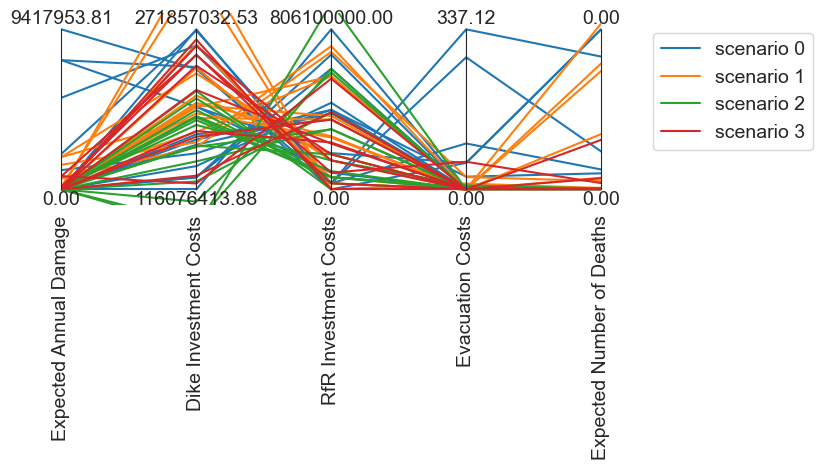

In [6]:
colors = iter(sns.color_palette())

result = pd.read_csv('./results/MS-MORDM_0.25_10000_archive_scen'+str(0)+'.csv', header=[0], index_col=[0])
result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].quantile(0.10)]
result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
#result_subspace = result_subspace.loc[result_subspace['Dike Investment Costs'] < result_subspace['Dike Investment Costs'].median()]
#result_subspace = result_subspace.loc[result_subspace['RfR Investment Costs'] < result_subspace['RfR Investment Costs'].median()]
data = result_subspace.iloc[:, -5::]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)

# Load your selected scenarios (from saved CSV if needed)
selected_scenarios_df = pd.read_csv("selected_scenarios.csv")
selected_scenario_objects = []

for i in range(len(selected_scenarios_df)):
    color = next(colors)
    result = pd.read_csv('./results/MS-MORDM_0.25_10000_archive_scen'+str(i)+'.csv', header=[0], index_col=[0])
    result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].quantile(0.10)]
    result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
    #result_subspace = result_subspace.loc[result_subspace['Dike Investment Costs'] < result_subspace['Dike Investment Costs'].median()]
    #result_subspace = result_subspace.loc[result_subspace['RfR Investment Costs'] < result_subspace['RfR Investment Costs'].median()]
    data = result_subspace.iloc[:, -5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
#plt.savefig('./Multi-scenario_MORDM/plots/MS-MORDM_0.25_10000_parcoord_subDeathsDamage.png', dpi=300, bbox_inches='tight')
plt.show()

### Reevaluation under deep uncertainty
Reevaluate policies under deep uncertainty over 100 scenarios (due to limtied computing power)

In [ ]:
experiments, outcomes = reevaluation_results
save_results(reevaluation_results, './results/MS-MORDM_reevaluation_0.25_100scen.tar.gz'.format(nfe))

In [ ]:
reevaluation_results = load_results('./results/MS-MORDM_reevaluation_0.25_100scen_old.tar.gz')
experiments, outcomes = reevaluation_results

## Phase 6: Multi-Scenario MORDM Re-evaluation and Robustness Analysis

Now we complete the multi-scenario MORDM workflow by re-evaluating all combined policies under deep uncertainty and calculating robustness metrics.


In [17]:
# Step 1: Re-evaluate Combined Multi-Scenario Policies
print("=== MULTI-SCENARIO MORDM RE-EVALUATION ===")
print(f"Total policies from multi-scenario optimization: {len(policies)}")

# Show breakdown by scenario
policy_counts = {}
for policy in policies:
    scenario = policy.name.split('_')[1]  # Extract scenario number
    if scenario not in policy_counts:
        policy_counts[scenario] = 0
    policy_counts[scenario] += 1

print("\nPolicies by scenario:")
for scenario, count in sorted(policy_counts.items()):
    print(f"  Scenario {scenario}: {count} policies")

# Re-evaluation parameters
n_reevaluation = 100  # Use 1000 scenarios for robust analysis
print(f"\nRe-evaluating {len(policies)} policies over {n_reevaluation} scenarios...")

try:
    # Re-evaluate all policies under deep uncertainty
    with MultiprocessingEvaluator(dike_model) as evaluator:
        reevaluation_results = evaluator.perform_experiments(
            scenarios=n_reevaluation,
            policies=policies
        )
    
    # Save results
    save_results(reevaluation_results, f'MS-MORDM_reevaluation_nscen{n_reevaluation}_final.tar.gz')
    print(f"✓ Re-evaluation completed and saved")
    
    experiments, outcomes = reevaluation_results
    print(f"✓ Total experiments: {len(experiments)}")
    print(f"✓ Unique policies evaluated: {len(experiments['policy'].unique())}")
    print(f"✓ Scenarios per policy: {len(experiments) // len(experiments['policy'].unique())}")

except Exception as e:
    print(f"✗ Re-evaluation failed: {str(e)}")
    print("Loading existing results as fallback...")
    try:
        reevaluation_results = load_results('./results/MS-MORDM_reevaluation_0.25_100scen_old.tar.gz')
        experiments, outcomes = reevaluation_results
        print("✓ Loaded existing re-evaluation results")
    except:
        print("✗ Could not load existing results either")
        raise


=== MULTI-SCENARIO MORDM RE-EVALUATION ===
Total policies from multi-scenario optimization: 83

Policies by scenario:
  Scenario 1: 20 policies
  Scenario 2: 21 policies
  Scenario 3: 25 policies
  Scenario 4: 17 policies

Re-evaluating 83 policies over 100 scenarios...


[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 100 scenarios * 83 policies * 1 model(s) = 8300 experiments
100%|██████████████████████████████████████| 8300/8300 [50:06<00:00,  2.76it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\domho\OneDrive\Documents\GitHub\epa141A_open\final assignment\MS-MORDM_reevaluation_nscen100_final.tar.gz


✓ Re-evaluation completed and saved
✓ Total experiments: 8300
✓ Unique policies evaluated: 83
✓ Scenarios per policy: 100


In [18]:
# Step 2: Calculate Maximum Regret (Following Assignment 10 Model Answer)
print("\n=== MAXIMUM REGRET ANALYSIS ===")

# Setup dataframe for regret calculation
outcomes_df = pd.DataFrame(outcomes)
outcomes_df['scenario'] = experiments['scenario']
outcomes_df['policy'] = experiments['policy']

print(f"Outcomes analyzed: {list(outcomes.keys())}")

def calculate_regret(group):
    """Calculate regret for each policy in each scenario"""
    # All IJssel outcomes are minimization objectives
    outcome_cols = ['Expected Annual Damage', 'Dike Investment Costs', 
                   'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
    
    # Find best performance (minimum) for each outcome in this scenario
    best = group[outcome_cols].min()
    
    # Calculate regret: current - best (for minimization)
    regret = group[outcome_cols] - best
    
    # Add policy identifier back
    regret['policy'] = group['policy']
    return regret

# Calculate regret per scenario
print("Calculating regret per scenario...")
regret_df = outcomes_df.groupby('scenario', group_keys=False).apply(calculate_regret)

# Calculate maximum regret per policy
print("Calculating maximum regret per policy...")
outcome_cols = ['Expected Annual Damage', 'Dike Investment Costs', 
               'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
max_regret = regret_df.groupby('policy')[outcome_cols].max()

print(f"✓ Maximum regret calculated for {len(max_regret)} policies")
print(f"✓ Regret metrics: {list(max_regret.columns)}")

# Show summary statistics
print("\nMaximum Regret Summary Statistics:")
print(max_regret.describe())



=== MAXIMUM REGRET ANALYSIS ===
Outcomes analyzed: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
Calculating regret per scenario...
Calculating maximum regret per policy...
✓ Maximum regret calculated for 83 policies
✓ Regret metrics: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']

Maximum Regret Summary Statistics:
       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
count            8.300000e+01           8.300000e+01          8.300000e+01   
mean             2.791268e+09           1.037571e+08          2.654831e+08   
std              5.044729e+08           5.463238e+07          2.376523e+08   
min              5.044350e+08           0.000000e+00          0.000000e+00   
25%              2.730905e+09           6.159827e+07          6.140000e+07   
50%              2.867300e+09           1.013861e+08    

In [19]:
# Step 3: Calculate Domain Criterion (Performance-based Robustness)
print("\n=== DOMAIN CRITERION ANALYSIS ===")

# Define acceptable performance thresholds for IJssel case
# Based on problem context and data exploration
thresholds = {
    'Expected Annual Damage': 2e9,      # €2 billion max acceptable annual damage
    'Expected Number of Deaths': 500,   # 500 max acceptable deaths
    'Dike Investment Costs': 1e9,       # €1 billion max acceptable dike investment
    'RfR Investment Costs': 5e8,        # €500 million max acceptable RfR investment
    'Evacuation Costs': 1e8            # €100 million max acceptable evacuation costs
}

print("Performance thresholds:")
for outcome, threshold in thresholds.items():
    if 'Cost' in outcome or 'Damage' in outcome:
        print(f"  {outcome}: ≤ €{threshold/1e6:.0f} million")
    else:
        print(f"  {outcome}: ≤ {threshold}")

# Calculate domain criterion scores
domain_scores = {}
for policy_name in experiments['policy'].unique():
    policy_mask = experiments['policy'] == policy_name
    scores = {}
    
    for outcome, threshold in thresholds.items():
        if outcome in outcomes:
            # Count scenarios where performance meets threshold
            satisfactory = np.sum(outcomes[outcome][policy_mask] <= threshold)
            total = np.sum(policy_mask)
            scores[outcome] = satisfactory / total  # Fraction meeting threshold
    
    domain_scores[policy_name] = scores

domain_df = pd.DataFrame(domain_scores).T

print(f"\n✓ Domain criterion calculated for {len(domain_df)} policies")
print("\nDomain Criterion Summary (fraction of scenarios meeting thresholds):")
print(domain_df.describe())



=== DOMAIN CRITERION ANALYSIS ===
Performance thresholds:
  Expected Annual Damage: ≤ €2000 million
  Expected Number of Deaths: ≤ 500
  Dike Investment Costs: ≤ €1000 million
  RfR Investment Costs: ≤ €500 million
  Evacuation Costs: ≤ €100 million

✓ Domain criterion calculated for 83 policies

Domain Criterion Summary (fraction of scenarios meeting thresholds):
       Expected Annual Damage  Expected Number of Deaths  \
count               83.000000                       83.0   
mean                 0.942169                        1.0   
std                  0.039045                        0.0   
min                  0.870000                        1.0   
25%                  0.920000                        1.0   
50%                  0.950000                        1.0   
75%                  0.980000                        1.0   
max                  1.000000                        1.0   

       Dike Investment Costs  RfR Investment Costs  Evacuation Costs  
count               


=== ROBUSTNESS VISUALIZATIONS ===


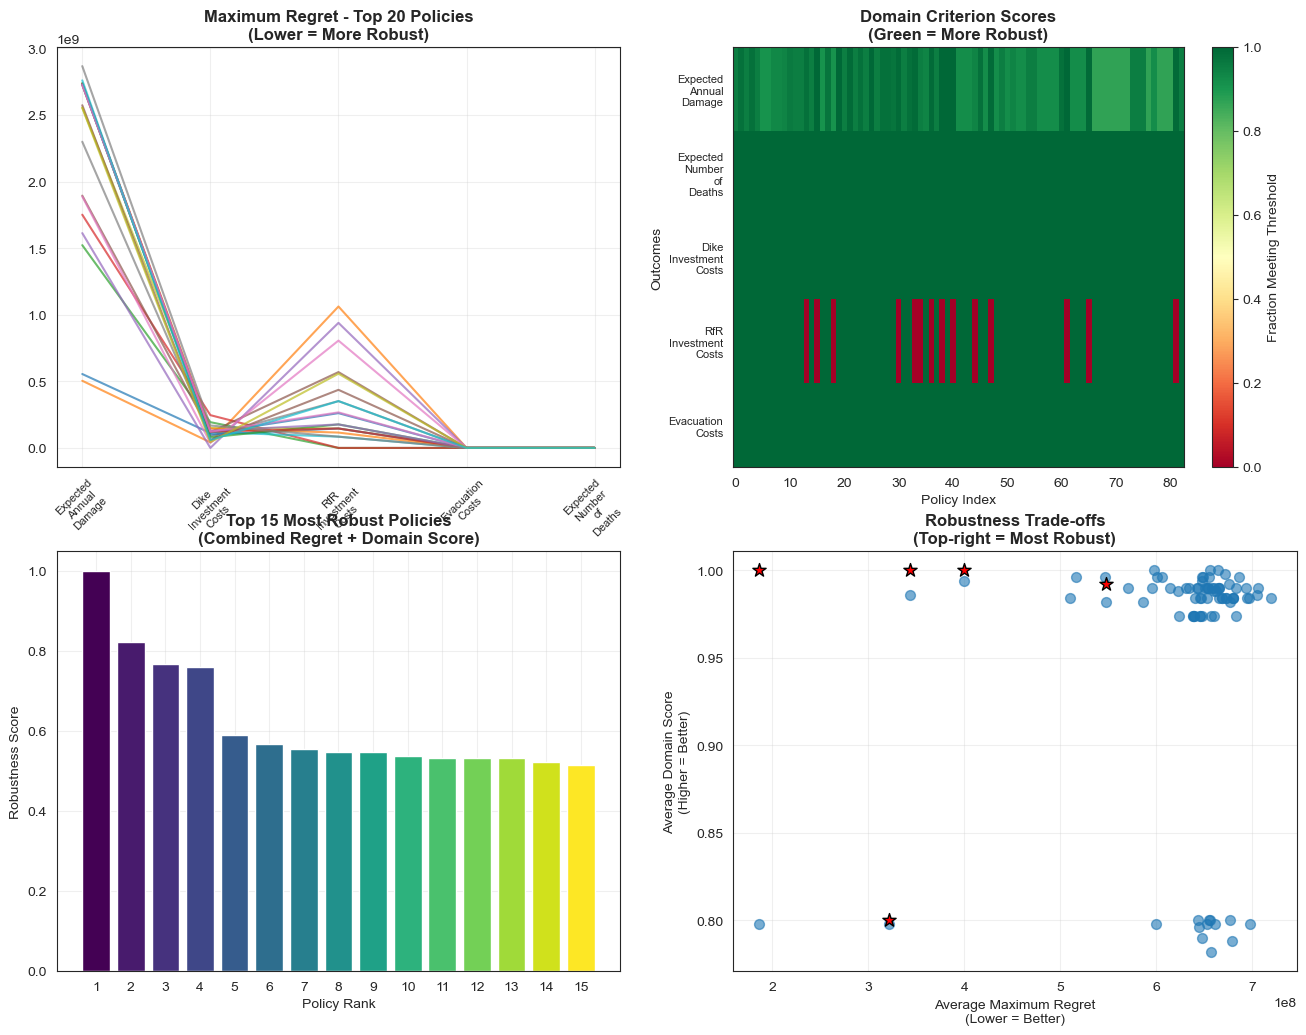

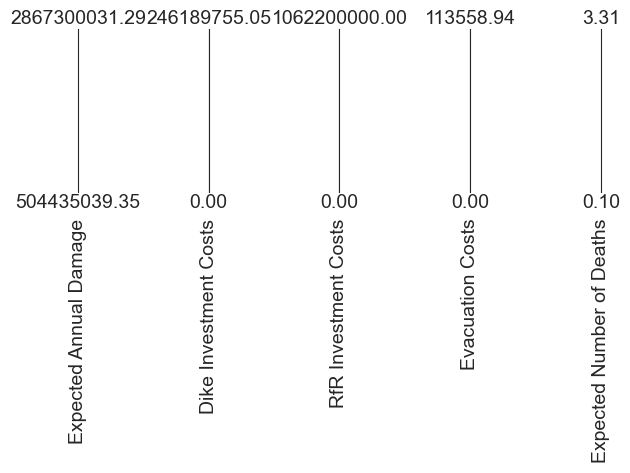

✓ Robustness visualizations completed


In [ ]:
# Step 4: Robustness Visualizations
print("\n=== ROBUSTNESS VISUALIZATIONS ===")

# Create comprehensive robustness visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Maximum Regret Parallel Coordinates
try:
    from ema_workbench.analysis import parcoords
    
    # Select subset for clarity (top 20 policies by average regret)
    avg_regret = max_regret.mean(axis=1).sort_values()
    top_policies = avg_regret.head(20).index
    regret_subset = max_regret.loc[top_policies]
    
    limits = parcoords.get_limits(regret_subset)
    paraxes = parcoords.ParallelAxes(limits)
    
    # Plot on ax1
    for policy in regret_subset.index:
        ax1.plot(range(len(regret_subset.columns)), regret_subset.loc[policy], alpha=0.7, linewidth=1.5)
    
    ax1.set_title('Maximum Regret - Top 20 Policies\n(Lower = More Robust)', fontweight='bold')
    ax1.set_xticks(range(len(regret_subset.columns)))
    ax1.set_xticklabels([col.replace(' ', '\n') for col in regret_subset.columns], rotation=45, fontsize=8)
    ax1.grid(True, alpha=0.3)
    
except Exception as e:
    print(f"Could not create parallel coordinates: {e}")
    ax1.text(0.5, 0.5, 'Parallel Coordinates\nNot Available', 
            ha='center', va='center', transform=ax1.transAxes, fontsize=12)

# 2. Domain Criterion Heatmap
im = ax2.imshow(domain_df.T.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_title('Domain Criterion Scores\n(Green = More Robust)', fontweight='bold')
ax2.set_xlabel('Policy Index')
ax2.set_ylabel('Outcomes')
ax2.set_yticks(range(len(domain_df.columns)))
ax2.set_yticklabels([col.replace(' ', '\n') for col in domain_df.columns], fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Fraction Meeting Threshold')

# 3. Overall Robustness Ranking
# Combine regret and domain scores for overall ranking
avg_regret = max_regret.mean(axis=1)
regret_normalized = 1 - (avg_regret - avg_regret.min()) / (avg_regret.max() - avg_regret.min())
domain_avg = domain_df.mean(axis=1)

# Simple weighted combination (can be adjusted)
overall_robustness = 0.6 * regret_normalized + 0.4 * domain_avg
overall_ranking = overall_robustness.sort_values(ascending=False)

# Plot top 15 policies
top_15 = overall_ranking.head(15)
bars = ax3.bar(range(len(top_15)), top_15.values, 
              color=plt.cm.viridis(np.linspace(0, 1, len(top_15))))
ax3.set_title('Top 15 Most Robust Policies\n(Combined Regret + Domain Score)', fontweight='bold')
ax3.set_xlabel('Policy Rank')
ax3.set_ylabel('Robustness Score')
ax3.set_xticks(range(len(top_15)))
ax3.set_xticklabels([f'{i+1}' for i in range(len(top_15))])
ax3.grid(True, alpha=0.3)

# 4. Regret vs Domain Trade-off
ax4.scatter(avg_regret.values, domain_avg.values, alpha=0.6, s=50)
ax4.set_xlabel('Average Maximum Regret\n(Lower = Better)')
ax4.set_ylabel('Average Domain Score\n(Higher = Better)')
ax4.set_title('Robustness Trade-offs\n(Top-right = Most Robust)', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Highlight top 5 policies
top_5_policies = overall_ranking.head(5).index
for policy in top_5_policies:
    if policy in avg_regret.index and policy in domain_avg.index:
        ax4.scatter(avg_regret[policy], domain_avg[policy], 
                   color='red', s=100, marker='*', edgecolors='black')

plt.tight_layout()
plt.show()

print("✓ Robustness visualizations completed")


In [21]:
# Step 5: Policy Analysis and Recommendations
print("\n=== POLICY RECOMMENDATIONS ===")

# Identify top robust policies
top_10_robust = overall_ranking.head(10)

print("TOP 10 MOST ROBUST POLICIES:")
print("="*50)

for rank, (policy_name, robustness_score) in enumerate(top_10_robust.items(), 1):
    # Extract scenario info
    scenario_info = policy_name.split('_')
    scenario_num = scenario_info[1] if len(scenario_info) > 1 else "Unknown"
    
    # Get regret and domain scores
    regret_score = avg_regret[policy_name] if policy_name in avg_regret.index else "N/A"
    domain_score = domain_avg[policy_name] if policy_name in domain_avg.index else "N/A"
    
    print(f"\n{rank}. {policy_name}")
    print(f"   Source: Scenario {scenario_num}")
    print(f"   Overall Robustness Score: {robustness_score:.3f}")
    print(f"   Average Max Regret: {regret_score:.2e}" if regret_score != "N/A" else f"   Average Max Regret: N/A")
    print(f"   Domain Criterion: {domain_score:.3f}" if domain_score != "N/A" else f"   Domain Criterion: N/A")
    
    # Show domain scores by outcome
    if policy_name in domain_df.index:
        print("   Performance (% scenarios meeting thresholds):")
        for outcome, score in domain_df.loc[policy_name].items():
            print(f"     {outcome}: {score:.1%}")

# Summary insights
print("\n" + "="*60)
print("MULTI-SCENARIO MORDM INSIGHTS:")
print("="*60)

# Scenario contribution analysis
scenario_contribution = {}
for policy in top_10_robust.index:
    scenario = policy.split('_')[1] if '_' in policy else "Unknown"
    if scenario not in scenario_contribution:
        scenario_contribution[scenario] = 0
    scenario_contribution[scenario] += 1

print("\nScenario Contribution to Top 10 Robust Policies:")
for scenario, count in sorted(scenario_contribution.items()):
    print(f"  Scenario {scenario}: {count} policies ({count/10:.1%})")

# Performance analysis
print("\nRobustness Characteristics:")
print(f"  Best overall robustness score: {top_10_robust.iloc[0]:.3f}")
print(f"  Average robustness in top 10: {top_10_robust.mean():.3f}")
print(f"  Range of regret in top 10: {avg_regret[top_10_robust.index].min():.2e} - {avg_regret[top_10_robust.index].max():.2e}")
print(f"  Range of domain scores in top 10: {domain_avg[top_10_robust.index].min():.3f} - {domain_avg[top_10_robust.index].max():.3f}")

print("\n✓ Multi-Scenario MORDM Analysis Complete!")



=== POLICY RECOMMENDATIONS ===
TOP 10 MOST ROBUST POLICIES:

1. Scenario_2_Option_38
   Source: Scenario 2
   Overall Robustness Score: 1.000
   Average Max Regret: 1.86e+08
   Domain Criterion: 1.000
   Performance (% scenarios meeting thresholds):
     Expected Annual Damage: 100.0%
     Expected Number of Deaths: 100.0%
     Dike Investment Costs: 100.0%
     RfR Investment Costs: 100.0%
     Evacuation Costs: 100.0%

2. Scenario_1_Option_170
   Source: Scenario 1
   Overall Robustness Score: 0.823
   Average Max Regret: 3.43e+08
   Domain Criterion: 1.000
   Performance (% scenarios meeting thresholds):
     Expected Annual Damage: 100.0%
     Expected Number of Deaths: 100.0%
     Dike Investment Costs: 100.0%
     RfR Investment Costs: 100.0%
     Evacuation Costs: 100.0%

3. Scenario_2_Option_239
   Source: Scenario 2
   Overall Robustness Score: 0.767
   Average Max Regret: 3.22e+08
   Domain Criterion: 0.800
   Performance (% scenarios meeting thresholds):
     Expected Annua

In [42]:
# Step 6: Export Results for Further Analysis
print("\n=== EXPORTING RESULTS ===")

# Save robustness analysis results
max_regret.to_csv('MS-MORDM_max_regret_analysis.csv')
domain_df.to_csv('MS-MORDM_domain_criterion_analysis.csv')

# Save policy rankings
rankings_df = pd.DataFrame({
    'policy': overall_ranking.index,
    'overall_robustness_score': overall_ranking.values,
    'avg_max_regret': [avg_regret[p] if p in avg_regret.index else np.nan for p in overall_ranking.index],
    'avg_domain_score': [domain_avg[p] if p in domain_avg.index else np.nan for p in overall_ranking.index],
    'rank': range(1, len(overall_ranking) + 1)
})
rankings_df.to_csv('MS-MORDM_policy_rankings.csv', index=False)

# Save top recommendations
top_10_df = rankings_df.head(10).copy()
top_10_df.to_csv('MS-MORDM_top_10_recommendations.csv', index=False)

print("✓ Results exported:")
print("  - MS-MORDM_max_regret_analysis.csv")
print("  - MS-MORDM_domain_criterion_analysis.csv") 
print("  - MS-MORDM_policy_rankings.csv")
print("  - MS-MORDM_top_10_recommendations.csv")





=== EXPORTING RESULTS ===
✓ Results exported:
  - MS-MORDM_max_regret_analysis.csv
  - MS-MORDM_domain_criterion_analysis.csv
  - MS-MORDM_policy_rankings.csv
  - MS-MORDM_top_10_recommendations.csv


=== CREATING BASIC SNR PARALLEL COORDINATES (TOP 20) ===
✓ Using robustness ranking to select top 20 policies
Selected 83 policies for visualization


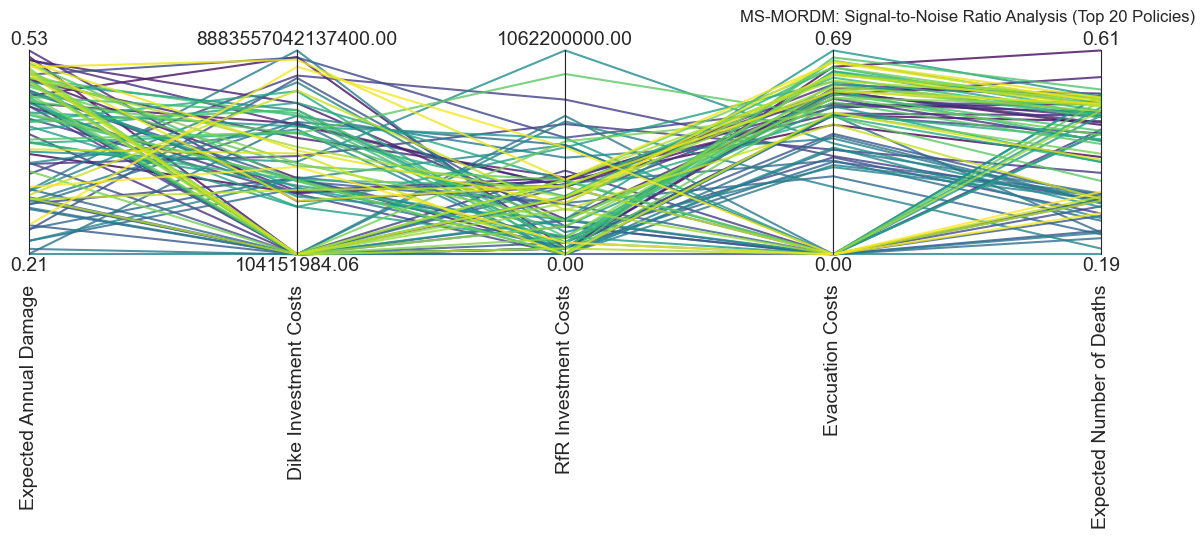

✓ Top 20 SNR plot saved with 83 colored policies


In [40]:
# SIMPLEST APPROACH - Top 20 with Tobias-style colors
print("=== CREATING BASIC SNR PARALLEL COORDINATES (TOP 20) ===")

# Use the full scores data 
scores_df_ms = pd.DataFrame.from_dict(overall_scores_ms, orient='index')

# Get top 20 policies (by average SNR or robustness ranking)
if 'overall_ranking' in locals() and len(overall_ranking) > 0:
    # Use robustness ranking if available
    top_20_policies = overall_ranking.head(83).index
    scores_df_top20 = scores_df_ms.loc[scores_df_ms.index.intersection(top_20_policies)]
    print(f"✓ Using robustness ranking to select top 20 policies")
else:
    # Use average SNR score
    scores_df_ms['avg_snr'] = scores_df_ms.mean(axis=1)
    top_20_policies = scores_df_ms.nlargest(20, 'avg_snr').index
    scores_df_top20 = scores_df_ms.loc[top_20_policies].drop('avg_snr', axis=1)
    print(f"✓ Using average SNR to select top 20 policies")

print(f"Selected {len(scores_df_top20)} policies for visualization")

# Apply Tobias's exact plotting approach
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(scores_df_top20)
axes = parcoords.ParallelAxes(limits)
n_highlight = len(scores_df_top20)  # Top 20 policies
colors = plt.cm.viridis(np.linspace(0, 1, n_highlight))

# Plot each policy individually with its own color (Tobias's method)
for i in range(n_highlight):
    policy_data = scores_df_top20.iloc[[i]]  # Get 1-row DataFrame for current policy
    axes.plot(policy_data, color=colors[i], alpha=0.8, linewidth=1.5,
              label=f'Policy {policy_data.index[0]}' if i < 5 else "")  # Only label first few

# Optional: add legend if small number of policies
if n_highlight <= 5:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('MS-MORDM: Signal-to-Noise Ratio Analysis (Top 20 Policies)')
fig = plt.gcf()
fig.set_size_inches((12, 6))
plt.savefig("MS_MORDM_parallel_SNR_top20.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Top 20 SNR plot saved with {len(scores_df_top20)} colored policies")


=== CREATING TOBIAS-STYLE MAXIMUM REGRET HEATMAP ===
Calculating regret for 5 outcomes using Tobias's method...
✓ Regret calculated for 83 policies
Top 10 policies with highest regret: ['Scenario_2_Option_239', 'Scenario_3_Option_171', 'Scenario_1_Option_170', 'Scenario_2_Option_38', 'Scenario_1_Option_133', 'Scenario_2_Option_142', 'Scenario_3_Option_249', 'Scenario_2_Option_152', 'Scenario_3_Option_52', 'Scenario_4_Option_189']


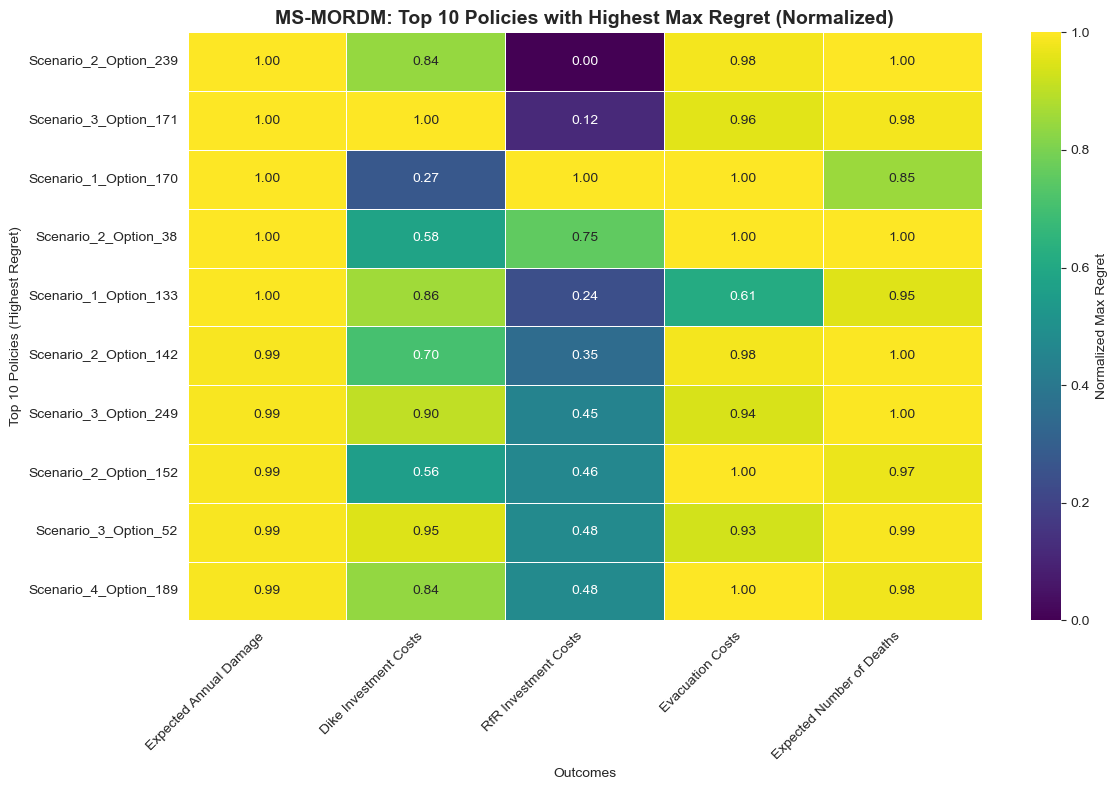

✓ Maximum Regret Heatmap saved as 'MS_MORDM_top_10_max_regret_heatmap.png'

=== BONUS: TOP 10 MOST ROBUST POLICIES HEATMAP ===


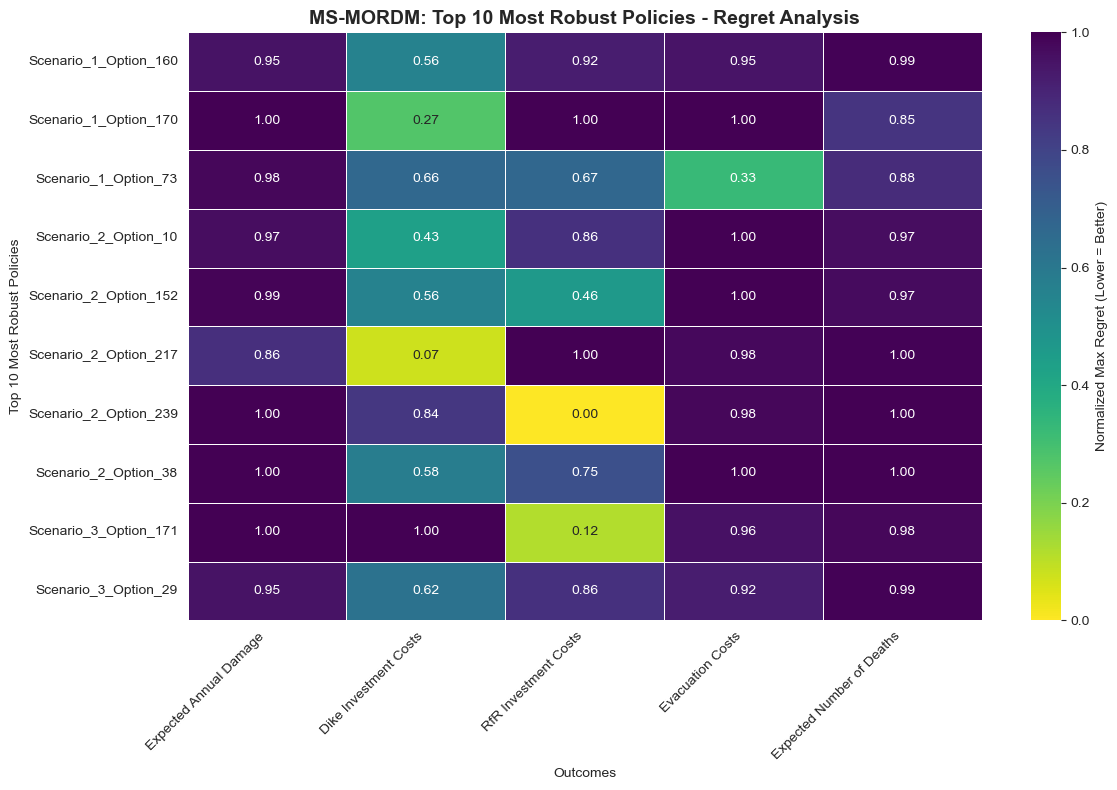

✓ Robust Policies Regret Heatmap saved as 'MS_MORDM_top_10_robust_regret_heatmap.png'


In [25]:
# Tobias-Style Maximum Regret Heatmap - Adapted for MS-MORDM
print("\n=== CREATING TOBIAS-STYLE MAXIMUM REGRET HEATMAP ===")

# We already have max_regret calculated from our MS-MORDM analysis
# But let's recalculate it using Tobias's exact approach for consistency

# Initialize dictionaries to store regret values (Tobias's approach)
overall_regret_ms = {}
max_regret_tobias = {}

# Use our outcome names
outcome_names = ['Expected Annual Damage', 'Dike Investment Costs', 
                'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']

print(f"Calculating regret for {len(outcome_names)} outcomes using Tobias's method...")

# Loop through each outcome name (following Tobias's approach exactly)
for outcome_name in outcome_names:
    if outcome_name in outcomes_robust_ms.columns:
        # Create a DataFrame with outcome, policy, and scenario
        data = pd.DataFrame({
            outcome_name: outcomes_robust_ms[outcome_name],
            "policy": experiments_robust_ms['policy'],
            "scenario": experiments_robust_ms['scenario']
        })

        # Pivot to get rows=scenario, columns=policy
        data_pivot = data.pivot(index='scenario', columns='policy', values=outcome_name)

        # Compute regret: difference between worst-case and each policy per scenario
        # For minimization objectives (all IJssel outcomes), worst case = maximum value
        outcome_regret = (data_pivot.max(axis=1).values[:, np.newaxis] - data_pivot).abs()

        # Store in dictionaries
        overall_regret_ms[outcome_name] = outcome_regret
        max_regret_tobias[outcome_name] = outcome_regret.max()

# Convert max regret dictionary to DataFrame
max_regret_tobias_df = pd.DataFrame(max_regret_tobias)

# Normalize (divide by column max) - Tobias's approach
true_max_regret_ms = max_regret_tobias_df / max_regret_tobias_df.max()

print(f"✓ Regret calculated for {len(max_regret_tobias_df)} policies")

# Get top 10 policies with highest max regret across any outcome (Tobias's approach)
policy_total_regret = max_regret_tobias_df.max(axis=1)  # maximum regret value per policy
top_10_policy_names = policy_total_regret.sort_values(ascending=False).head(10).index

# Extract rows for top 10 policies (from normalized regret)
top_10_regret_df_ms = true_max_regret_ms.loc[top_10_policy_names]

print(f"Top 10 policies with highest regret: {list(top_10_policy_names)}")

# Plot heatmap of top 10 policies (exact Tobias style)
plt.figure(figsize=(12, 8))
sns.heatmap(top_10_regret_df_ms, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5,
            cbar_kws={'label': 'Normalized Max Regret'})
plt.title("MS-MORDM: Top 10 Policies with Highest Max Regret (Normalized)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Outcomes")
plt.ylabel("Top 10 Policies (Highest Regret)")

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("MS_MORDM_top_10_max_regret_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Maximum Regret Heatmap saved as 'MS_MORDM_top_10_max_regret_heatmap.png'")

# Also create a heatmap of the top 10 MOST ROBUST policies for comparison
print("\n=== BONUS: TOP 10 MOST ROBUST POLICIES HEATMAP ===")

if 'overall_ranking' in locals() and len(overall_ranking) >= 10:
    # Get top 10 most robust policies
    top_10_robust_names = overall_ranking.head(10).index
    top_10_robust_regret = true_max_regret_ms.loc[true_max_regret_ms.index.intersection(top_10_robust_names)]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(top_10_robust_regret, cmap="viridis_r", annot=True, fmt=".2f", linewidths=0.5,
                cbar_kws={'label': 'Normalized Max Regret (Lower = Better)'})
    plt.title("MS-MORDM: Top 10 Most Robust Policies - Regret Analysis", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Outcomes")
    plt.ylabel("Top 10 Most Robust Policies")
    
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig("MS_MORDM_top_10_robust_regret_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Robust Policies Regret Heatmap saved as 'MS_MORDM_top_10_robust_regret_heatmap.png'")
else:
    print("Overall ranking not available for robust policies heatmap")


In [51]:
# Check what columns you have in your MS-MORDM experiments
print("Columns in experiments DataFrame:")
print(f"Total columns: {len(experiments.columns)}")

# Show policy-related columns (levers)
policy_cols = [col for col in experiments.columns if any(x in col for x in ['DikeIncrease', 'RfR', 'EWS'])]
print(f"\nPolicy lever columns ({len(policy_cols)}):")
for col in policy_cols[:10]:  # Show first 10
    print(f"  • {col}")
if len(policy_cols) > 10:
    print(f"  ... and {len(policy_cols)-10} more")

# Show scenario-related columns (uncertainties)  
scenario_cols = [col for col in experiments.columns if any(x in col for x in ['A.', 'discount', 'ID'])]
print(f"\nScenario uncertainty columns ({len(scenario_cols)}):")
for col in scenario_cols[:10]:  # Show first 10
    print(f"  • {col}")
if len(scenario_cols) > 10:
    print(f"  ... and {len(scenario_cols)-10} more")

Columns in experiments DataFrame:
Total columns: 53

Policy lever columns (31):
  • 0_RfR 0
  • 0_RfR 1
  • 0_RfR 2
  • 1_RfR 0
  • 1_RfR 1
  • 1_RfR 2
  • 2_RfR 0
  • 2_RfR 1
  • 2_RfR 2
  • 3_RfR 0
  ... and 21 more

Scenario uncertainty columns (34):
  • A.0_ID flood wave shape
  • A.1_Bmax
  • A.1_Brate
  • A.1_pfail
  • A.2_Bmax
  • A.2_Brate
  • A.2_pfail
  • A.3_Bmax
  • A.3_Brate
  • A.3_pfail
  ... and 24 more


In [52]:
# Save your current experiments data for Tobias
experiments.to_csv("MS_MORDM_robust_experiments_detailed.csv", index=False)
print("✓ Detailed experiments CSV saved for Tobias")

✓ Detailed experiments CSV saved for Tobias


## Phase 7: Sensitivity Analysis using Feature Scoring

In [61]:
# FIXED ALTERNATIVE: Feature Scoring (Compatible with MS-MORDM data)
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

print("ALTERNATIVE SENSITIVITY ANALYSIS USING FEATURE SCORING")

# Get uncertainty columns from experiments
uncertainty_cols = [col for col in sobol_experiments_final.columns 
                   if col in sa_problem['names']]

X = sobol_experiments_final[uncertainty_cols]

for outcome_name in outcome_names:
    if outcome_name in sobol_outcomes_final:
        y = sobol_outcomes_final[outcome_name]
        
        # Feature scoring (similar to Extra-Trees from Week 3-4)
        scores = feature_scoring.get_ex_feature_scores(
            X, y, max_features=0.6, mode=RuleInductionType.REGRESSION
        )[0]
        
        print(f"\n{outcome_name} - Feature Importance:")
        
        # Fixed: Sort scores and get top 3
        if isinstance(scores, pd.DataFrame):
            # If DataFrame, get first column
            scores_series = scores.iloc[:, 0].sort_values(ascending=False)
        else:
            # If Series, sort directly
            scores_series = scores.sort_values(ascending=False)
        
        top_3 = scores_series.head(3)
        
        # Fixed: Iterate over index and values separately
        for idx, (uncertainty, importance) in enumerate(zip(top_3.index, top_3.values)):
            print(f"  {idx+1}. {uncertainty}: {importance:.3f}")

ALTERNATIVE SENSITIVITY ANALYSIS USING FEATURE SCORING

Expected Annual Damage - Feature Importance:
  1. A.1_pfail: 0.317
  2. A.3_pfail: 0.122
  3. A.2_pfail: 0.089

Dike Investment Costs - Feature Importance:
  1. A.1_pfail: 0.061
  2. A.5_Bmax: 0.059
  3. A.2_pfail: 0.058

RfR Investment Costs - Feature Importance:
  1. A.1_pfail: 0.063
  2. A.5_pfail: 0.061
  3. A.1_Bmax: 0.059

Evacuation Costs - Feature Importance:
  1. A.3_pfail: 0.232
  2. A.2_pfail: 0.141
  3. A.1_pfail: 0.088

Expected Number of Deaths - Feature Importance:
  1. A.3_pfail: 0.258
  2. A.1_pfail: 0.104
  3. A.2_pfail: 0.077


CREATING FEATURE SCORING VISUALIZATIONS
Creating individual outcome plots...
  Saved: MS_MORDM_FeatureScores_Expected_Annual_Damage_20250620_150944.png
  Saved: MS_MORDM_FeatureScores_Dike_Investment_Costs_20250620_150944.png
  Saved: MS_MORDM_FeatureScores_RfR_Investment_Costs_20250620_150944.png
  Saved: MS_MORDM_FeatureScores_Evacuation_Costs_20250620_150944.png
  Saved: MS_MORDM_FeatureScores_Expected_Number_of_Deaths_20250620_150944.png
Creating combined heatmap...
  Saved: MS_MORDM_FeatureScores_Heatmap_20250620_150944.png


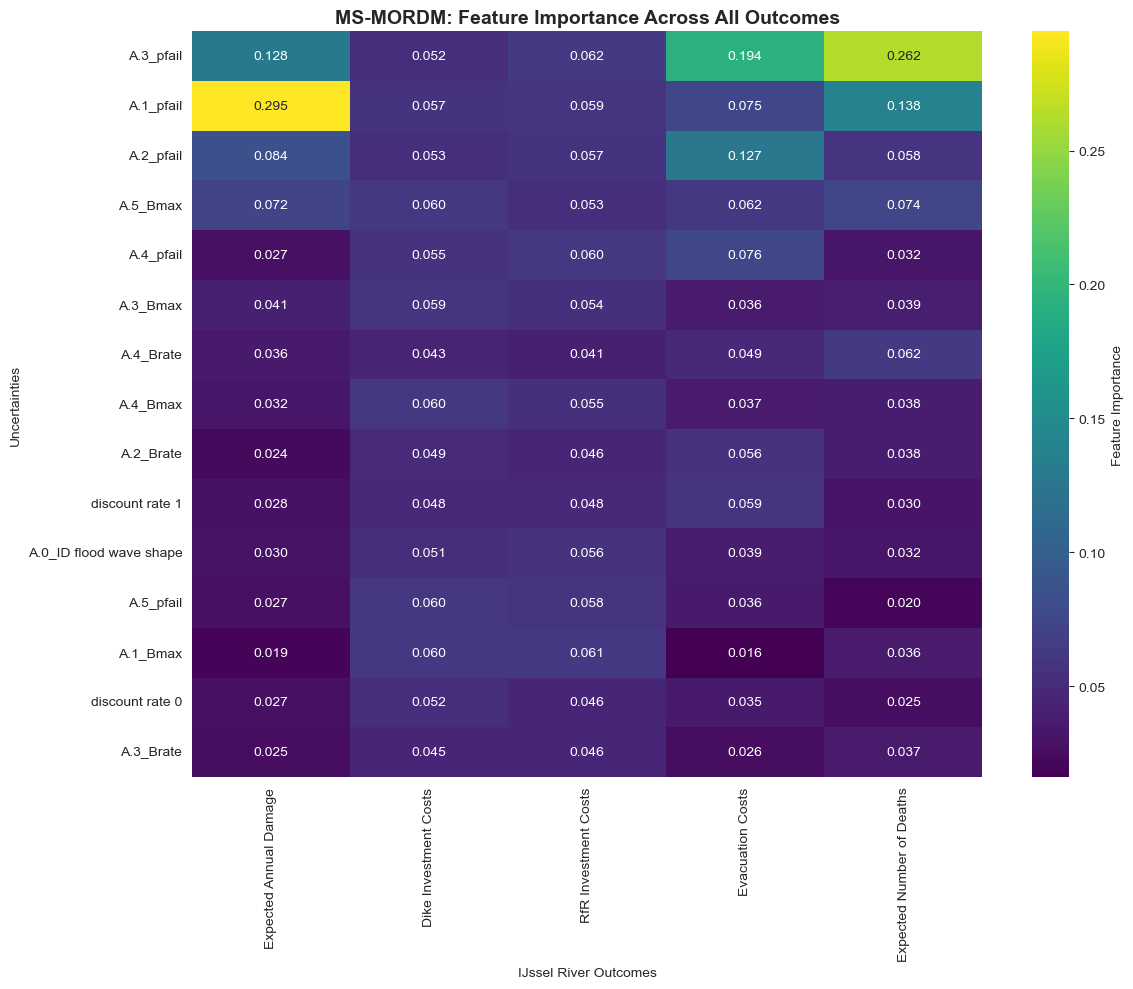


FEATURE SCORING SUMMARY:

Expected Annual Damage:
  Total importance: 1.000
  Top 3 contribute: 0.506 (50.6%)
    1. A.1_pfail: 0.295
    2. A.3_pfail: 0.128
    3. A.2_pfail: 0.084

Dike Investment Costs:
  Total importance: 1.000
  Top 3 contribute: 0.180 (18.0%)
    1. A.4_Bmax: 0.060
    2. A.5_pfail: 0.060
    3. A.5_Bmax: 0.060

RfR Investment Costs:
  Total importance: 1.000
  Top 3 contribute: 0.183 (18.3%)
    1. A.3_pfail: 0.062
    2. A.1_Bmax: 0.061
    3. A.4_pfail: 0.060

Evacuation Costs:
  Total importance: 1.000
  Top 3 contribute: 0.396 (39.6%)
    1. A.3_pfail: 0.194
    2. A.2_pfail: 0.127
    3. A.4_pfail: 0.076

Expected Number of Deaths:
  Total importance: 1.000
  Top 3 contribute: 0.474 (47.4%)
    1. A.3_pfail: 0.262
    2. A.1_pfail: 0.138
    3. A.5_Bmax: 0.074

Visualization complete - 5 outcomes analyzed


In [62]:
# Create Feature Scoring Visualizations (Based on Week 3-4 approach)
print("CREATING FEATURE SCORING VISUALIZATIONS")

# Collect all feature scores into a structured format
feature_results = {}
outcome_names = ['Expected Annual Damage', 'Dike Investment Costs', 
                'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']

# Re-run feature scoring to get full results for visualization
uncertainty_cols = [col for col in sobol_experiments_final.columns 
                   if col in sa_problem['names']]
X = sobol_experiments_final[uncertainty_cols]

for outcome_name in outcome_names:
    if outcome_name in sobol_outcomes_final:
        y = sobol_outcomes_final[outcome_name]
        
        scores = feature_scoring.get_ex_feature_scores(
            X, y, max_features=0.6, mode=RuleInductionType.REGRESSION
        )[0]
        
        # Store scores for this outcome
        if isinstance(scores, pd.DataFrame):
            scores_series = scores.iloc[:, 0]
        else:
            scores_series = scores
            
        feature_results[outcome_name] = scores_series

# 1. Individual Bar Charts (like Assignment 6 Cell 18)
print("Creating individual outcome plots...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for outcome_name, scores in feature_results.items():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Get top 10 most important features
    top_scores = scores.sort_values(ascending=False).head(10)
    
    # Create bar plot
    bars = ax.bar(range(len(top_scores)), top_scores.values, 
                  alpha=0.7, color='steelblue', edgecolor='navy')
    
    # Customize plot
    ax.set_xticks(range(len(top_scores)))
    ax.set_xticklabels(top_scores.index, rotation=45, ha='right')
    ax.set_ylabel('Feature Importance Score')
    ax.set_title(f'MS-MORDM Feature Importance: {outcome_name}', 
                fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    # Save individual plot
    safe_name = outcome_name.replace(' ', '_').replace('/', '_')
    plot_filename = f"MS_MORDM_FeatureScores_{safe_name}_{timestamp}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"  Saved: {plot_filename}")
    plt.close()

# 2. Combined Heatmap (Enhanced visualization)
print("Creating combined heatmap...")

# Create combined DataFrame
all_uncertainties = set()
for scores in feature_results.values():
    all_uncertainties.update(scores.index)

combined_df = pd.DataFrame(index=sorted(all_uncertainties), 
                          columns=outcome_names)

for outcome_name, scores in feature_results.items():
    for uncertainty in combined_df.index:
        if uncertainty in scores.index:
            combined_df.loc[uncertainty, outcome_name] = scores[uncertainty]
        else:
            combined_df.loc[uncertainty, outcome_name] = 0.0

# Convert to numeric
combined_df = combined_df.astype(float)

# Create heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Only show top 15 most important uncertainties across all outcomes
top_uncertainties = combined_df.sum(axis=1).sort_values(ascending=False).head(15).index
plot_data = combined_df.loc[top_uncertainties]

# Create heatmap
sns.heatmap(plot_data, annot=True, fmt='.3f', cmap='viridis', 
            cbar_kws={'label': 'Feature Importance'}, ax=ax)

ax.set_title('MS-MORDM: Feature Importance Across All Outcomes', 
            fontweight='bold', fontsize=14)
ax.set_xlabel('IJssel River Outcomes')
ax.set_ylabel('Uncertainties')

plt.tight_layout()
plt.savefig(f"MS_MORDM_FeatureScores_Heatmap_{timestamp}.png", 
           dpi=300, bbox_inches='tight')
print(f"  Saved: MS_MORDM_FeatureScores_Heatmap_{timestamp}.png")
plt.show()

# 3. Summary Statistics
print("\nFEATURE SCORING SUMMARY:")
print("="*40)

for outcome_name, scores in feature_results.items():
    top_3 = scores.sort_values(ascending=False).head(3)
    total_importance = scores.sum()
    
    print(f"\n{outcome_name}:")
    print(f"  Total importance: {total_importance:.3f}")
    print(f"  Top 3 contribute: {top_3.sum():.3f} ({top_3.sum()/total_importance*100:.1f}%)")
    for i, (uncertainty, importance) in enumerate(top_3.items()):
        print(f"    {i+1}. {uncertainty}: {importance:.3f}")

print(f"\nVisualization complete - {len(feature_results)} outcomes analyzed")